In [2]:
import os
from os.path import join
import pickle
import torch
import numpy as np
from pysdf import SDF
import trimesh
from manotorch.manolayer import ManoLayer
from tqdm import *

def convert_to_obj_frame(pc, obj_rot, obj_trans):
    pc = (obj_rot.T @ (pc - obj_trans).T).T
    return pc

def get_close(contact):
        return np.sum(np.abs(contact[np.abs(contact)<0.01]))

datapath = '/root/code/seqs/1205_data/'
obj_path = '/root/code/seqs/object/'
manolayer = ManoLayer(
    mano_assets_root='/root/code/CAMS/data/mano_assets/mano',
    side='right'
)

mano_knuckles_file = '/root/code/CAMS/data/preparation/mano_parts_1.pt' # MANO part file of knuckles
mano_parts_d = torch.load(mano_knuckles_file) # 1552面
verts_part_d = np.zeros(778, dtype=np.int32)
mano_faces = manolayer.get_mano_closed_faces()
for face_id in range(mano_faces.shape[0]):
    verts_part_d[mano_faces[face_id, 0]] = mano_parts_d[face_id]
    verts_part_d[mano_faces[face_id, 1]] = mano_parts_d[face_id]
    verts_part_d[mano_faces[face_id, 2]] = mano_parts_d[face_id]
verts_part_d = torch.from_numpy(verts_part_d)

tips = [15,3,6,12,9]

seqs = sorted(os.listdir(datapath))
grasp_id = []

    


/root/anaconda3/envs/mdm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pysdf'

In [15]:
grasp_dict = {}
seqs = sorted(os.listdir(datapath))
for seq in tqdm(seqs):
    seq_path = join(datapath,seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
        hand_trans = hand_params[:,:3]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]
        active_obj = meta['active_obj']
        obj_mesh_path = join(obj_path,active_obj,'simplified_scan_processed.obj')
        obj_mesh = trimesh.load(obj_mesh_path)
        obj_pose = torch.tensor(np.load(join(seq_path,active_obj+'_pose_trans.npy'))).float()
        obj_rot = obj_pose[:,:,:3]
        obj_trans = obj_pose[:,:,3]
        obj_sdf = SDF(obj_mesh.vertices,obj_mesh.faces)
        for i in range(len(hand_params)):
            thumb_flag = False
            finger_flag = False
            save_flag = False
            mano_output = manolayer(hand_theta[i].unsqueeze(0), mano_beta[i].unsqueeze(0))
            mano_verts = mano_output.verts[0] - mano_output.joints[0, 0] + hand_trans[i]
            mano_verts = convert_to_obj_frame(mano_verts.squeeze(),
                                                obj_rot[i],
                                                obj_trans[i])
            # hand_faces = manolayer.get_mano_closed_faces()
            hand_contact = obj_sdf(mano_verts)
            # print(hand_contact.shape)
            if get_close(hand_contact) > 0:
                for tip in tips:
                    tip_contact = hand_contact[verts_part_d == tip]
                    tip_close = get_close(tip_contact)
                    if tip == 15:
                        if tip_close > 0:
                            thumb_flag = True
                    else:
                        if tip_close > 0 :
                            finger_flag = True
                if thumb_flag and finger_flag:
                    grasp_dict[seq] = i
                    # print(seq,i)
                    break
            else:
                if i == len(hand_params) - 1:
                    print(seq,"failed.")
        # break
    else:
        continue

 13%|█▎        | 185/1378 [19:25<2:13:06,  6.69s/it]

0185 failed.


 25%|██▍       | 338/1378 [38:16<6:04:50, 21.05s/it]

0338 failed.


 25%|██▍       | 341/1378 [39:29<6:27:11, 22.40s/it]

0341 failed.


 28%|██▊       | 381/1378 [46:53<5:19:46, 19.24s/it]

0381 failed.


 35%|███▌      | 484/1378 [57:34<1:41:45,  6.83s/it]

0484 failed.


 44%|████▍     | 605/1378 [1:18:13<9:29:38, 44.22s/it]

0605 failed.


 55%|█████▍    | 756/1378 [1:41:31<3:00:53, 17.45s/it]

0756 failed.


 55%|█████▍    | 757/1378 [1:42:49<5:03:44, 29.35s/it]

0757 failed.


 56%|█████▌    | 765/1378 [1:44:39<3:26:49, 20.24s/it]

0765 failed.


 56%|█████▌    | 766/1378 [1:45:53<5:07:17, 30.13s/it]

0766 failed.


 64%|██████▎   | 878/1378 [2:04:31<3:57:33, 28.51s/it]

0878 failed.


 70%|███████   | 971/1378 [2:20:38<1:34:40, 13.96s/it]

0971 failed.


 78%|███████▊  | 1072/1378 [2:42:51<37:27,  7.34s/it]  

1072 failed.


 87%|████████▋ | 1194/1378 [2:56:15<57:33, 18.77s/it]  

1194 failed.


100%|██████████| 1378/1378 [3:37:48<00:00,  9.48s/it]  


In [ ]:
# grasp_dict = {}
def get_close(contact):
        return np.sum(np.abs(contact[np.abs(contact)<0.03]))
fail_seqs = ['0185','0338','0341','0381','0484','0605','0756','0765','0766','0878','0971','1072','1194']
for seq in tqdm(fail_seqs):
    seq_path = join(datapath,seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
        hand_trans = hand_params[:,:3]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]
        active_obj = meta['active_obj']
        print(active_obj)
        obj_mesh_path = join(obj_path,active_obj,'simplified_scan_processed.obj')
        obj_mesh = trimesh.load(obj_mesh_path)
        obj_pose = torch.tensor(np.load(join(seq_path,active_obj+'_pose_trans.npy'))).float()
        obj_rot = obj_pose[:,:,:3]
        obj_trans = obj_pose[:,:,3]
        obj_sdf = SDF(obj_mesh.vertices,obj_mesh.faces)
        for i in range(len(hand_params)):
            thumb_flag = False
            finger_flag = False
            save_flag = False
            mano_output = manolayer(hand_theta[i].unsqueeze(0), mano_beta[i].unsqueeze(0))
            mano_verts = mano_output.verts[0] - mano_output.joints[0, 0] + hand_trans[i]
            mano_verts = convert_to_obj_frame(mano_verts.squeeze(),
                                                obj_rot[i],
                                                obj_trans[i])
            # hand_faces = manolayer.get_mano_closed_faces()
            hand_contact = obj_sdf(mano_verts)
            # print(hand_contact.shape)
            if get_close(hand_contact) > 0:
                for tip in tips:
                    tip_contact = hand_contact[verts_part_d == tip]
                    tip_close = get_close(tip_contact)
                    print(tip,tip_close)
                    if tip == 15:
                        if tip_close > 0:
                            thumb_flag = True
                    else:
                        if tip_close > 0 :
                            finger_flag = True
                if thumb_flag and finger_flag:
                    grasp_dict[seq] = i
                    # print(seq,i)
                    break
            else:
                if i == len(hand_params) - 1:
                    print(seq,"failed.")
        # break
    else:
        continue

In [44]:
print(grasp_dict)

{'0001': 14, '0003': 14, '0006': 14, '0007': 13, '0008': 16, '0013': 8, '0019': 10, '0020': 19, '0023': 11, '0024': 10, '0026': 7, '0028': 14, '0031': 15, '0032': 14, '0035': 19, '0037': 20, '0038': 14, '0040': 14, '0042': 18, '0044': 35, '0047': 12, '0048': 18, '0051': 10, '0052': 61, '0055': 18, '0056': 20, '0058': 22, '0061': 16, '0062': 34, '0065': 25, '0067': 34, '0068': 13, '0071': 25, '0072': 27, '0075': 47, '0076': 30, '0079': 44, '0080': 47, '0083': 38, '0084': 38, '0087': 38, '0088': 2, '0091': 43, '0092': 42, '0094': 29, '0096': 36, '0099': 19, '0101': 36, '0102': 3, '0103': 43, '0105': 11, '0106': 8, '0107': 8, '0109': 1, '0111': 62, '0112': 29, '0113': 10, '0114': 46, '0115': 38, '0118': 42, '0119': 33, '0145': 52, '0146': 3, '0147': 72, '0148': 7, '0149': 18, '0150': 9, '0155': 17, '0156': 11, '0160': 48, '0161': 59, '0162': 63, '0163': 43, '0164': 64, '0168': 42, '0169': 33, '0170': 46, '0171': 19, '0172': 75, '0176': 26, '0177': 43, '0178': 34, '0179': 14, '0181': 18, '

In [45]:
goals = np.array(list(grasp_dict.values()))
print(goals.max())

192


In [37]:
goals_seq = list(grasp_dict.keys())
print(goals_seq)

['0001', '0003', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0019', '0020', '0023', '0024', '0026', '0028', '0031', '0032', '0035', '0037', '0038', '0040', '0042', '0044', '0047', '0048', '0051', '0052', '0055', '0056', '0058', '0061', '0062', '0065', '0067', '0068', '0071', '0072', '0075', '0076', '0079', '0080', '0083', '0084', '0087', '0088', '0091', '0092', '0094', '0096', '0099', '0101', '0102', '0103', '0105', '0106', '0107', '0109', '0111', '0112', '0113', '0114', '0115', '0118', '0119', '0121', '0124', '0127', '0130', '0133', '0140', '0143', '0145', '0146', '0147', '0148', '0149', '0150', '0155', '0156', '0160', '0161', '0162', '0163', '0164', '0168', '0169', '0170', '0171', '0172', '0176', '0177', '0178', '0179', '0181', '0183', '0186', '0187', '0189', '0191', '0192', '0194', '0195', '0196', '0197', '0198', '0200', '0201', '0203', '0204', '0205', '0206', '0207', '0209', '0210', '0211', '0214', '0215', '0219', '0220', '0221',

In [40]:
seq_002 = []
for seq in goals_seq:
    seq_path = join(datapath,seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
        hand_trans = hand_params[:,:3]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]
        active_obj = meta['active_obj']
        # print(active_obj)
        if active_obj.startswith('002_qua') or active_obj.startswith('002_tri'):
            seq_002.append(seq)



In [42]:
# seq_002
for seq in seq_002:
    del grasp_dict[seq]

# 去掉失败的部分

In [56]:
for seq,index in grasp_dict.items():
    seq_path = join(datapath,seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    # print(meta)
    if meta['hand_flag'] == 'right':
        hand_params = np.load(join(seq_path,'mano/poses_right.npy'))
    #     meta['goal_index'] = index
    # with open(meta_path,'wb')as f:
    #     pickle.dump(meta, f)
    break

In [58]:
hand_pose = hand_params[:5,:3]

In [64]:
valid_seqs = list(grasp_dict.keys())

In [65]:
len(valid_seqs)

765

In [55]:
trainpath = '/root/code/seqs/gazehoi_list_train_new.txt'
testpath = '/root/code/seqs/gazehoi_list_test_new.txt'
        
with open(trainpath,'r') as f:
    train_list = f.readlines()
with open(testpath,'r') as f:
    test_list = f.readlines()

valid_seqs = []
for info in train_list:
    seq = info.strip()
    valid_seqs.append(seq)
for info in test_list:
    seq = info.strip()
    valid_seqs.append(seq)


In [56]:
len(valid_seqs)

765

In [71]:
len(seqs),len(new_seqs)

(750, 684)

In [72]:
f=open("/root/code/seqs/gazehoi_list_train_new.txt","w")
 
# f.writelines(test)
for line in new_seqs:
    f.write(line+'\n')
f.close()

In [78]:
path1 = '/root/code/OmniControl/dataset/kit_spatial_norm/Mean_raw.npy'
print(np.load(path1).shape)

(63,)


In [79]:
path1 = '/root/code/OmniControl/dataset/kit_mean.npy' 
print(np.load(path1).shape)

(251,)


# 计算mean

In [ ]:
valid_seqs

In [63]:
# seqs = sorted(os.listdir(valid_seqs))
from tqdm import *
hands_list = []
joint_list = []
for seq in tqdm(valid_seqs):
    seq_path = join('/root/code/seqs/1205_data/',seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
        hand_trans = hand_params[:,:3]
        hand_rot = hand_params[:,3:6]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]

        gt_output = manolayer(hand_theta, mano_beta)
        # 相对表示
        gt_joints = gt_output.joints - gt_output.joints[:, 0].unsqueeze(1) + hand_trans.unsqueeze(1)
        joint_list.append(gt_joints)
        # hands_list.append(hand_params)
        # hand_trans = hand_params[:,:3]
        # hand_theta = hand_params[:,3:51]
        # mano_beta = hand_params[:,51:]

100%|██████████| 765/765 [00:13<00:00, 55.88it/s] 


In [21]:
# seqs = sorted(os.listdir(valid_seqs))
from tqdm import *
from utils.data_util import obj_global2local_matrix, obj_matrix2rot6d
hands_list = []
joint_list = []
local_obj_pose_6d_list = []
global_obj_pose_6d_list = []
for seq in tqdm(valid_seqs):
    seq_path = join('/root/code/seqs/1205_data/',seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    if meta['hand_flag'] == 'right':
        obj_name_list = meta['obj_name_list']
        for obj in obj_name_list:
            obj_pose = torch.tensor(np.load(join(seq_path,obj+'_pose_trans.npy')).reshape(-1,3,4))
            obj_pose_local = obj_global2local_matrix(obj_pose.unsqueeze(0))
            obj_pose_local_6d = obj_matrix2rot6d(obj_pose_local)
            obj_pose_global_6d = obj_matrix2rot6d(obj_pose.unsqueeze(0))
            local_obj_pose_6d_list.append(obj_pose_local_6d.squeeze(0))
            global_obj_pose_6d_list.append(obj_pose_global_6d.squeeze(0))
    
        
        # hands_list.append(hand_params)
        # hand_trans = hand_params[:,:3]
        # hand_theta = hand_params[:,3:51]
        # mano_beta = hand_params[:,51:]

100%|██████████| 765/765 [00:03<00:00, 243.31it/s]


In [25]:
local_data = np.concatenate(local_obj_pose_6d_list, axis=0)
global_data = np.concatenate(global_obj_pose_6d_list, axis=0)

In [26]:
local_data.shape, global_data.shape

((474789, 9), (474789, 9))

In [32]:
# hands_pose = data[:,:51]
# print(hands_pose.shape)
data = global_data
mean = data.mean(axis=0)
std = data.std(axis=0)

std[:3] = std[:3].mean() / 1.0
std[3:] = std[3:].mean() / 1.0

print(mean,std)


[ 0.79933405 -0.72934205 -1.19342614 -0.21386048  0.00379753  0.17496449
  0.09812263 -0.05653823 -0.04264879] [0.13808932 0.13808932 0.13808932 0.56078171 0.56078171 0.56078171
 0.56078171 0.56078171 0.56078171]


In [33]:
np.save('/root/code/OmniControl/dataset/gazehoi_global_obj_mean.npy', mean)
np.save('/root/code/OmniControl/dataset/gazehoi_global_obj_std.npy', std)

In [68]:
mean,std.shape

(array([[ 0.65283066, -0.87845784, -1.3190148 ],
        [ 0.6552333 , -0.84926456, -1.3022171 ],
        [ 0.66498834, -0.83184993, -1.2834679 ],
        [ 0.68043625, -0.82334834, -1.267413  ],
        [ 0.69987905, -0.81139255, -1.2479547 ],
        [ 0.65505785, -0.84640986, -1.2444972 ],
        [ 0.67369163, -0.8385318 , -1.2257823 ],
        [ 0.6897996 , -0.83293426, -1.2187285 ],
        [ 0.7052852 , -0.82371163, -1.2139604 ],
        [ 0.663287  , -0.8641404 , -1.2366261 ],
        [ 0.68344283, -0.85599595, -1.2219536 ],
        [ 0.69989264, -0.8476628 , -1.2189465 ],
        [ 0.7173478 , -0.8390383 , -1.2199993 ],
        [ 0.6740651 , -0.88206345, -1.2463697 ],
        [ 0.68853736, -0.8710868 , -1.2313952 ],
        [ 0.7053893 , -0.86183923, -1.2284079 ],
        [ 0.7201399 , -0.8533746 , -1.2264625 ],
        [ 0.6846773 , -0.89362437, -1.2567991 ],
        [ 0.698029  , -0.88793355, -1.2473216 ],
        [ 0.70955783, -0.8794469 , -1.2435588 ],
        [ 0.7200982 

In [95]:
std[:3] = std[:3].mean() / 1.0
std[3:6] = std[3:6].mean() / 1.0
std[6:] = std[6:].mean() / 1.0

In [67]:
np.save('/root/code/OmniControl/dataset/gazehoi_global_joint_mean.npy', mean)
np.save('/root/code/OmniControl/dataset/gazehoi_global_joint_std.npy', std)

In [97]:
mean.shape

(51,)

In [28]:
res = np.load('/root/code/OmniControl/save/my_omnicontrol2/samples_my_omnicontrol2_000050000_seed10_predefined/results.npy',allow_pickle=True).item()

In [108]:
print(res.keys())

dict_keys(['motion', 'lengths', 'hint', 'seqs', 'num_samples', 'num_repetitions'])


In [113]:
len(set(res['seqs']))

81

In [29]:
def simple_eval(x, hint, n_joints=22):
    # mask = hint != 0
    # hint = hint * raw_std + raw_mean
    # hint = hint * mask
    # hint = hint.transpose((0, 2, 1))
    # print(hint.shape,motion.shape)
    # # hint = hint.reshape(hint.shape[0], , -1)
    # mask = hint.sum(axis=1, keepdims=True) != 0
    # print(mask.shape)
    # loss = np.linalg.norm((motion - hint) * mask, axis=1)
    # loss = loss.sum() / mask.sum()
    mask_hint = hint.view(hint.shape[0], hint.shape[1], 17, 3).sum(dim=-1, keepdim=True) != 0

    x_ = x.permute(0, 3, 2, 1).contiguous()
    x_ = x_.squeeze(2)
    bs,nf,_ = x_.shape
    print(hint.shape,x.shape,mask_hint.shape)
    loss = torch.norm((x_.reshape(bs,nf,-1,3) - hint.reshape(bs,nf,-1,3)) * mask_hint, dim=-1)
    return loss

In [30]:
# from utils.simple_eval import simple_eval
all_motions = torch.tensor(res['motion'])
all_hint = torch.tensor(res['hint'])
loss = simple_eval(all_motions, all_hint)
# print(loss)
print("Guide: ",torch.mean(loss[:,0]))

torch.Size([81, 60, 51]) torch.Size([81, 51, 1, 60]) torch.Size([81, 60, 17, 1])
Guide:  tensor(0.0207, dtype=torch.float64)


In [116]:
all_hint.shape

(81, 60, 51)

# 可视化生成结果

In [47]:
import numpy as np
import torch
import pickle
path = '/root/code/OmniControl/save/guide_delay2/samples_guide_delay2_000030000_seed10_predefined/results.npy'
res = np.load(path,allow_pickle=True).item()
pred_motion = torch.tensor(res['motion']).permute(0, 3, 2, 1).squeeze(2).contiguous()
hint = torch.tensor(res['hint'])
print(hint.shape)
seqs = res['seqs']
pred_motion.shape

torch.Size([81, 60, 51])


torch.Size([81, 60, 51])

In [ ]:
from pytorch3d.transforms import rotation_6d_to_matrix,axis_angle_to_matrix

res_save_path = path.replace('npy','txt')
print(res_save_path)
stage1_eval(pred_motion, hint, seqs, res_save_path)

In [2]:
def cal_goal_err(x, hint):
    """
    每个joints的平均偏差?
    """
    mask_hint = hint.view(hint.shape[0], hint.shape[1], 17, 3).sum(dim=-1, keepdim=True) != 0
    x_ = x
    print(x.shape)
    bs,nf,_ = x_.shape
    loss = torch.norm((x_.reshape(bs,nf,-1,3) - hint.reshape(bs,nf,-1,3)) * mask_hint, dim=-1)
    # print(loss[:,0])
    loss = loss[:,0] # bs,17
    # loss = torch.sum(loss) / bs
    loss = torch.mean(loss[:,0])
    return loss

def stage1_eval(pred_motion, all_hint, all_seqs, res_save_path):
    pred_motion = torch.tensor(pred_motion)
    hint = torch.tensor(all_hint)
    goal_err = cal_goal_err(pred_motion,hint)

    num_samples = pred_motion.shape[0]


    datapath = '/root/code/seqs/1205_data/'
    manolayer = ManoLayer(mano_assets_root='/root/code/CAMS/data/mano_assets/mano',side='right')
    obj_path = '/root/code/seqs/object/'

    total_hand_T_error = 0
    total_hand_R_error = 0
    total_mpjpe = 0 # root-relative
    total_traj_invalid_10 = 0
    total_traj_invalid_20 = 0
    total_traj_num = 0
    total_hand_R_error = 0

    for i in range(pred_motion.shape[0]):
        seq = seqs[i]
        seq_path = join(datapath,seq)

        meta_path = join(seq_path,'meta.pkl')
        with open(meta_path,'rb')as f:
            meta = pickle.load(f)
            
        active_obj = meta['active_obj']
        obj_pose = np.load(join(seq_path,active_obj+'_pose_trans.npy'))
        
        goal_index = meta['goal_index']
        obj_pose = torch.tensor(obj_pose[:goal_index+1]).float()

        if goal_index < 59:
            hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))[:goal_index+1]
        else:
            hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))[goal_index-59:goal_index+1]

        hand_trans = hand_params[:,:3]
        hand_rot = hand_params[:,3:6]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]

        pred_trans = torch.flip(pred_motion[i,:goal_index+1,:3],dims=[0])
        pred_theta = torch.flip(pred_motion[i,:goal_index+1,3:],dims=[0])
        pred_rot = torch.flip(pred_motion[i,:goal_index+1,3:6],dims=[0])

        pred_output = manolayer(pred_theta, mano_beta)
        # 相对表示
        pred_joints = pred_output.joints - pred_output.joints[:, 0].unsqueeze(1)
        gt_output = manolayer(hand_theta, mano_beta)
        # 相对表示
        gt_joints = gt_output.joints - gt_output.joints[:, 0].unsqueeze(1)
        mpjpe = torch.sum(torch.norm(pred_joints - gt_joints, dim=-1)) / (hand_trans.shape[0] * 21)
        total_mpjpe += mpjpe

        hand_T_error = torch.sum(torch.norm(hand_trans-pred_trans,p=2,dim=-1)) / hand_trans.shape[0]
        total_hand_T_error += hand_T_error

        hand_rot = axis_angle_to_matrix(hand_rot)
        pred_rot = axis_angle_to_matrix(pred_rot)
        hand_rot = torch.einsum('...ij->...ji', [hand_rot])
        hand_R_error = (torch.einsum('fpn,fnk->fpk',hand_rot,pred_rot) - torch.eye(3).unsqueeze(0).repeat(hand_rot.shape[0],1,1)).reshape(-1,9) # nf,3,3
        hand_R_error =  torch.sum(torch.norm(hand_R_error,dim=-1)) /hand_trans.shape[0]
        total_hand_R_error += hand_R_error

        traj_error = torch.norm(hand_trans-pred_trans,p=2,dim=1) 
        traj_invalid_10 = torch.sum(traj_error > 0.1)
        traj_invalid_20 = torch.sum(traj_error > 0.2)
        total_traj_invalid_10 += traj_invalid_10
        total_traj_invalid_20 += traj_invalid_20
        total_traj_num += traj_error.shape[0]
    
    with open(res_save_path, 'w') as f:
        f.write(f'Goal Error:{goal_err:.6f}\n')
        f.write(f'Traj Error (<10cm):{(total_traj_invalid_10/total_traj_num):.6f}\n')
        f.write(f'Traj Error (<20cm):{(total_traj_invalid_20/total_traj_num):.6f}\n')
        f.write(f'Hand Trans Error:{total_hand_T_error/num_samples:.6f}\n')
        f.write(f'Hand Rot Error:{total_hand_R_error/num_samples:.6f}\n')
        f.write(f'MPJPE :{total_mpjpe/num_samples:.6f}\n')

In [6]:

from manotorch.manolayer import ManoLayer
from os.path import join
import json
import os
os.environ['MUJOCO_GL'] = 'osmesa'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
def vis_smpl(out_path, image, nf, vertices, faces, camera_R, camera_T, K = np.array([1031.8450927734375, 0.0, 932.1596069335938, 0.0, 1022.4588623046875, 541.9437255859375, 0.0, 0.0, 1.0]).reshape((3,3))):
    outname = os.path.join(out_path, '{:06d}.jpg'.format(nf))
    # if os.path.exists(outname): return
    render_data = {}
    assert vertices.shape[1] == 3 and len(vertices.shape) == 2, 'shape {} != (N, 3)'.format(vertices.shape)
    render_data = {"vertices": vertices, "faces": faces, "vid":0, "name": "human_{}_0".format(nf)}

    camera = {"K": K,
        "R": camera_R,
        "T":camera_T}
    from visualize.renderer import Renderer
    render = Renderer(height=3840, width=2160, faces=None)
    image_vis, depth = render.render(render_data, camera, image, add_back=True)
    # print(depth)
    cv2.imwrite(outname, image_vis)
    return image_vis, depth  

datapath = '/root/code/seqs/1205_data/'
manolayer = ManoLayer(mano_assets_root='/root/code/CAMS/data/mano_assets/mano',side='right')
faces = manolayer.th_faces
view = 5
calib_path = "/root/code/seqs/calibration_all.json"
with open(calib_path) as f:
    calib_dome = json.load(f)
    f.close()
camera_pose = np.vstack((np.asarray(calib_dome[str(view)]['RT']).reshape((3,4)), np.ones(4) ))
K = np.asarray(calib_dome[str(view)]['K']).reshape((3,3))

for i in range(pred_motion.shape[0]):
    seq = seqs[i]
    seq_path = join(datapath,seq)
    hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
    hand_trans = hand_params[:,:3]
    hand_theta = hand_params[:,3:51]
    mano_beta = hand_params[:,51:]

    pred_trans = pred_motion[i,:,:3]
    pred_theta = pred_motion[i,:,3:]
    mano_output = manolayer(pred_theta, mano_beta[:goal+1])
    print(mano_output.verts.shape,mano_output.joints.shape,pred_trans.shape)
    mano_verts = mano_output.verts - mano_output.joints[:, 0].unsqueeze(1) + pred_trans.unsqueeze(1)
    render_out = join('/root/code/OmniControl/save/guide_delay2/samples_guide_delay2_000030000_seed10_predefined/','render')
    os.makedirs(render_out,exist_ok=True)
    for k in range(len(mano_verts)):
        img = np.zeros((2160, 3840,3), np.uint8) 
        
        _, depth = vis_smpl(render_out, img, k, mano_verts[k], faces,camera_pose[:3,:3],camera_pose[:3,3],K)
        break

NameError: name 'pred_motion' is not defined

In [77]:
a = np.random.randn(1,10)
b = a[:,-10:]
print(a)
print(b)

[[-0.90727966  0.46295225 -0.35474287  1.6237592  -0.29448975 -1.81806888
   0.26575419  1.02130978 -1.11818234  2.30116171]]
[[-0.90727966  0.46295225 -0.35474287  1.6237592  -0.29448975 -1.81806888
   0.26575419  1.02130978 -1.11818234  2.30116171]]


In [100]:
def lengths_to_mask(lengths, max_len):
    # max_len = max(lengths)
    mask = torch.arange(max_len-1,-1,-1).expand(len(lengths), max_len) < lengths.unsqueeze(1)
    return mask

In [99]:
torch.arange(5,0,-1)

tensor([5, 4, 3, 2, 1])

In [101]:
lens = torch.tensor([[2],[3]])
print(lens.shape)
lengths_to_mask(lens,3)

torch.Size([2, 1])


tensor([[[False,  True,  True],
         [False,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True]]])

In [111]:
hand_params.shape

torch.Size([150, 61])

In [78]:
import numpy as np
from os.path import join
import torch
from pytorch3d.transforms import  quaternion_to_axis_angle,axis_angle_to_quaternion, axis_angle_to_matrix, matrix_to_rotation_6d,rotation_6d_to_matrix,matrix_to_axis_angle
from data_loaders.humanml.common.quaternion import qinv, qmul
seq_path = '/root/code/seqs/1205_data/0001/'
hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy')))
hand_motion = hand_params[:,:51]
hand_motion = (hand_motion.unsqueeze(0).repeat(10,1,1)).contiguous()
print(hand_motion.shape)

torch.Size([10, 175, 51])


In [62]:
# from utils.data_util import  global2local_axis,local2global_axis

raw = hand_motion
# local = global2local_axis(raw)
# after_axis = local2global_axis(local)
print(raw.shape)
after_rot = axis2rot6d(raw)
print(after_rot.shape)
axis = rot6d2axis(after_rot)
print((after_axis-axis)[0,2])
print(torch.sum(after_axis-axis)/(1750*51))

torch.Size([10, 175, 51])
torch.Size([10, 175, 99])
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.2167e+00, -3.4285e+00,
        -4.1685e+00, -7.4506e-09,  1.4901e-08, -5.9605e-08, -1.8626e-09,
         3.5482e-10, -5.9605e-08, -9.3132e-10,  8.7587e-11, -2.9802e-08,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4901e-08, -1.9550e-09,
         0.0000e+00,  0.0000e+00,  2.3411e-10,  0.0000e+00, -2.9802e-08,
        -1.4901e-08,  0.0000e+00,  1.4901e-08,  0.0000e+00,  0.0000e+00,
         1.4901e-08, -2.3381e-10, -1.4901e-08,  7.4506e-09, -4.4703e-08,
        -5.9605e-08, -7.4506e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.9605e-08, -5.9605e-08,  2.9802e-08,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])
tensor(-0.0023)


In [76]:
theta = raw[0,2,3:].reshape(-1,3).unsqueeze(0)
# print(theta)
rot6d = matrix_to_rotation_6d(axis_angle_to_matrix(theta))
theta_after = matrix_to_axis_angle(rotation_6d_to_matrix(rot6d))
diff = theta_after - theta
# print(diff)
# print(abs(diff) > 1e-6)
print(axis_angle_to_quaternion(theta))
print(axis_angle_to_quaternion(theta_after))

tensor([[[ 5.3535e-01,  4.3242e-01, -4.6088e-01, -5.6036e-01],
         [ 9.5530e-01,  4.3895e-02, -9.3296e-02,  2.7707e-01],
         [ 9.8818e-01,  9.1567e-03,  0.0000e+00,  1.5302e-01],
         [ 9.9764e-01,  4.1005e-03,  0.0000e+00,  6.8522e-02],
         [ 9.6868e-01, -4.8997e-02,  2.3991e-02,  2.4225e-01],
         [ 9.6427e-01, -4.6077e-02,  0.0000e+00,  2.6090e-01],
         [ 9.9590e-01, -1.5728e-02, -3.7406e-09,  8.9057e-02],
         [ 9.5400e-01, -1.8771e-01,  1.1988e-01,  2.0069e-01],
         [ 9.9200e-01, -7.4046e-02,  0.0000e+00,  1.0220e-01],
         [ 9.9686e-01, -4.6456e-02,  7.4740e-09,  6.4119e-02],
         [ 9.7246e-01, -5.9505e-02,  1.2219e-01,  1.8935e-01],
         [ 9.5948e-01, -5.0303e-02,  0.0000e+00,  2.7725e-01],
         [ 9.9440e-01, -1.8873e-02,  0.0000e+00,  1.0402e-01],
         [ 9.0321e-01,  3.4466e-01, -1.8801e-01,  1.7339e-01],
         [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.000

In [33]:
import torch
from pytorch3d.transforms import  quaternion_to_axis_angle,axis_angle_to_quaternion, axis_angle_to_matrix, matrix_to_rotation_6d,rotation_6d_to_matrix,matrix_to_axis_angle
from data_loaders.humanml.common.quaternion import qinv, qmul
def axis2rot6d(motion):
    # motion (bs, frames, 51)
    bs, nf, _ = motion.shape
    motion_rot_axis = motion[:,:,3:].reshape(bs,nf,-1,3)
    motion_rot_6d = matrix_to_rotation_6d(axis_angle_to_matrix(motion_rot_axis))
    motion_rot_6d = motion_rot_6d.reshape(bs, nf, -1)
    motion = torch.cat((motion[:,:,:3], motion_rot_6d),dim=-1)
    return motion

def rot6d2axis(motion):
    # motion (bs, frames, 99)
    bs, nf, _ = motion.shape
    motion_rot_6d = motion[:,:,3:].reshape(bs,nf,-1,6)
    motion_axis = matrix_to_axis_angle(rotation_6d_to_matrix(motion_rot_6d))
    motion_axis = motion_axis.reshape(bs, nf, -1)
    motion = torch.cat((motion[:,:,:3], motion_axis),dim=-1)
    return motion 
    
def get_vel_axis(motion):
    # motion (bs, frames, 51)
    trans = motion[:,:,:3]
    rot_axis = motion[:,:,3:6]
    l_velocity = trans[:,1:] - trans[:,:-1] #bs, frames-1 ,3

    rot_qua = axis_angle_to_quaternion(rot_axis)
    print(rot_qua[:,:-1].shape)
    r_velocity = qmul(rot_qua[:,1:], qinv(rot_qua[:,:-1]))
    r_velocity = quaternion_to_axis_angle(r_velocity)

    return l_velocity, r_velocity

def global2local_axis(motion):
    # 只对global RT做相对变换
    l_velocity, r_velocity = get_vel_axis(motion)
    motion[:,1:,:3] = l_velocity
    motion[:,1:,3:6] = r_velocity
    return motion


def local2global_axis(motion):
    # 只对global RT做相对变换
    l_velocity = motion[:,:,:3]
    r_velocity = motion[:,:,3:6]

    trans = torch.cumsum(l_velocity,dim=1)

    r_velocity = axis_angle_to_quaternion(r_velocity)
    nf = l_velocity.shape[1]
    rot = r_velocity[:,0].unsqueeze(1)
    cur_r = rot
    for i in range(1,nf):
        rot_i = qmul(r_velocity[:,i].unsqueeze(1), cur_r)
        cur_r = rot_i
        # print(rot_i.shape)
        rot = torch.cat((rot,rot_i),dim=1)
    rot = quaternion_to_axis_angle(rot)
    motion[:,:,:3] = trans
    motion[:,:,3:6] = rot

    return motion




In [104]:
def get_vel_axis_by_matrix(motion):
    trans = motion[:,:,:3]
    rot_axis = motion[:,:,3:6]
    l_velocity = trans[:,1:] - trans[:,:-1] #bs, frames-1 ,3

    rot_matrix = axis_angle_to_matrix(rot_axis) # bs. frames, 3, 3
    matrix_0 = rot_matrix[:,:-1] # 需要求逆
    matrix_1 = rot_matrix[:,1:]
    matrix_0_inv = torch.einsum('...ij->...ji', [matrix_0])
    r_velocity = torch.einsum('fipn,fink->fipk',matrix_1,matrix_0_inv)
    r_velocity = matrix_to_axis_angle(r_velocity)
    return l_velocity, r_velocity

def global2local_axis_by_matrix(motion):
    l_velocity, r_velocity = get_vel_axis_by_matrix(motion)
    # motion[:,1:,:3] = l_velocity
    # motion[:,1:,3:6] = r_velocity
    new_motion = motion.clone()
    new_motion[:, 1:, :3] = l_velocity
    new_motion[:, 1:, 3:6] = r_velocity
    return new_motion

def local2global_axis_by_matrix(motion):
     # 只对global RT做相对变换
    l_velocity = motion[:,:,:3]
    r_velocity = motion[:,:,3:6]

    trans = torch.cumsum(l_velocity,dim=1)

    r_velocity = axis_angle_to_matrix(r_velocity)
    print(r_velocity.shape)
    # matrices = [r for r in r_velocity]
    # rot = torch.chain_matmul(*matrices)
    nf = l_velocity.shape[1]
    rot = r_velocity[:,0].unsqueeze(1) #bs,1,3,3
    cur_r = rot
    for i in range(1,nf):
        # print(r_velocity[:,i].unsqueeze(1).shape, cur_r.shape)
        rot_i = torch.einsum('fipn,fink->fipk',r_velocity[:,i].unsqueeze(1),cur_r)
        cur_r = rot_i
        rot = torch.cat((rot,rot_i),dim=1)

    print(rot.shape)
    rot = matrix_to_axis_angle(rot)
    print(rot.shape)
    new_motion = motion.clone()
    new_motion[:,:,:3] = trans
    new_motion[:,:,3:6] = rot
    return new_motion

In [105]:
local = global2local_axis_by_matrix(hand_motion)
global_after = local2global_axis_by_matrix(local)

torch.Size([10, 175, 3, 3])
torch.Size([10, 175, 3, 3])
torch.Size([10, 175, 3])


In [106]:
local = global2local_axis(hand_motion)
global_after = local2global_axis(local)

torch.Size([10, 174, 4])


In [2]:
trainpath = '/root/code/seqs/gazehoi_list_train_new.txt'
testpath = '/root/code/seqs/gazehoi_list_test_new.txt'
        
with open(trainpath,'r') as f:
    train_list = f.readlines()
with open(testpath,'r') as f:
    test_list = f.readlines()

valid_seqs = []
for info in train_list:
    seq = info.strip()
    valid_seqs.append(seq)
for info in test_list:
    seq = info.strip()
    valid_seqs.append(seq)

In [2]:
len(valid_seqs)

765

In [18]:
import pickle
from sklearn.neighbors import KDTree
from tqdm import *
import torch
import numpy as np
from os.path import join
motion_list = []
hint_list = []
lens = []
obj_path = '/root/code/seqs/object/'

def convert_to_obj_frame(points, obj_pose):
    # points(frames,5,3)
    # obj_pose (frames,3,4)

    # pc = (obj_rot.T @ (pc - obj_trans).T).T
    obj_T = obj_pose[:,:3,3].unsqueeze(1)
    # print(obj_T.shape)
    points = points - obj_T
    # hand_rot = torch.einsum('...ij->...ji', [hand_rot])
    # hand_R_error = (torch.einsum('fpn,fnk->fpk',hand_rot,pred_rot) - torch.eye(3).unsqueeze(0).repeat(hand_rot.shape[0],1,1)).reshape(-1,9) # nf,3,3
       
    points = torch.einsum('...ij->...ji', [points])
    obj_R = obj_pose[:,:3,:3]
    obj_R = torch.einsum('...ij->...ji', [obj_R])
    new_points = torch.einsum('fpn,fnk->fpk',obj_R,points)
    new_points = torch.einsum('...ij->...ji', [new_points])

    return new_points

for seq in tqdm(valid_seqs):
    seq_path = join('/root/code/seqs/1205_data/',seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    goal_index = meta['goal_index']
    active_obj = meta['active_obj']
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy'))).float()
        lens.append(hand_params.shape[0])
        """
        # obj_pose = torch.tensor(np.load(join(seq_path,active_obj+'_pose_trans.npy'))).float()
        # # print(hand_params.shape, obj_pose.shape)
        # obj_verts = torch.tensor(np.load(join(obj_path,active_obj,'resampled_500_trans.npy'))).float()
        # goal_obj_pose = obj_pose[goal_index]
        # # obj_verts = obj_verts @ goal_obj_pose[:3,:3].T + goal_obj_pose[:3,3].reshape(1,3)
        # kdt = KDTree(obj_verts)
        
        # hand_trans = hand_params[:,:3]
        # hand_rot = hand_params[:,3:6]
        # hand_theta = hand_params[:,3:51]
        # mano_beta = hand_params[:,51:]

        # gt_output = manolayer(hand_theta, mano_beta)
        # gt_joints = gt_output.joints - gt_output.joints[:, 0].unsqueeze(1) + hand_trans.unsqueeze(1)

        # tips = [15,3,6,12,9]
        # tips_T = gt_joints[goal_index:,tips]
        # # print(tips_T.shape)
        # obj_pose = obj_pose[goal_index:]
        # tips_to_obj = convert_to_obj_frame(tips_T, obj_pose) # (frames,5,3) (frames,3,4)
        # # print(tips_to_obj.shape)
        # ds, ids = kdt.query(tips_to_obj.reshape(-1,3), k=1)
        # ids = torch.from_numpy(ids)
        # ds = torch.from_numpy(ds)
        # # print(ds.shape, ids.shape)
        # target_verts = obj_verts[ids.squeeze()].reshape(-1,5,3)
        # ids = ids.reshape(-1,5)
        # # print(ids.shape, target_verts.shape)
        # # print(ids[0].shape)
        
        # target_ds = ds.reshape(-1,5)
        # # print(target_verts[0],target_ds[0],tips_to_obj[0])
        # # dis = torch.norm(target_verts - tips_to_obj,dim=-1)
        # # print(dis[0],target_ds[0])
        # # print(target_verts[0].shape,target_ds[0].shape)
        # res = torch.cat((ids[0].unsqueeze(-1),target_ds[0].unsqueeze(-1)),dim=-1)
        # # print(res.shape)
        # # break
        # # print(res)
        # # print(res.shape)

        # # break
        # np.save(join(seq_path,'tips_closest_id_and_dis.npy'), res)
        """

        # pc = tips_T[0]
        # obj_rot = goal_obj_pose[:3,:3]
        # obj_trans = goal_obj_pose[:3,3]
        # pc = (obj_rot.T @ (pc - obj_trans).T).T
        # nn = torch.from_numpy(kdt.query(pc.reshape(-1,3), k=1)[1])
        # target_verts = obj_verts[nn.squeeze()]
        # print(target_verts)
        # print(pc)



        # break
       


        # obj_T = obj_T.unsqueeze(1)
        # tip_obj_dis = torch.norm(tips_T - obj_T,dim=-1).numpy()
        # np.save(join(seq_path,'tip_distance.npy'), tip_obj_dis)

        # hand_T = hand_params[goal_index:,:3]
        # obj_T = obj_pose[goal_index:,:3,3]
        # distance = torch.norm(hand_T-obj_T,dim=-1).numpy()
        # np.save(join(seq_path,'global_distance.npy'), distance)
        
        # print(distanc
        # seq_len = hand_params.shape[0] - goal_index
        # lens.append(seq_len)


        # print(tip_obj_dis.shape, tip_obj_dis[0])

        # break
        # joint_list.append(gt_joints)
        # hand_motion = hand_params[:,:51]

        # local_motion = global2local_axis_by_matrix(hand_motion.unsqueeze(0))
        # local_motion_6d = axis2rot6d(local_motion)
        # motion_list.append(local_motion_6d.squeeze(0))

        # global_motion_6d = axis2rot6d(hand_motion.unsqueeze(0))
        # hint_list.append(global_motion_6d.squeeze(0))


  0%|          | 0/765 [00:00<?, ?it/s]

100%|██████████| 765/765 [00:00<00:00, 3248.11it/s]


In [19]:
lens = np.array(lens)
lens.max(),lens.min()

(345, 84)

In [129]:
# print(hands_list[0].shape)
local_motions = torch.cat(motion_list, dim=0).numpy()
global_motions = torch.cat(hint_list, dim=0).numpy()
# print(hand_motions.shape)

In [133]:
mean = global_motions.mean(axis=0)
std = global_motions.std(axis=0)
std[:3] = std[:3].mean() / 1.0
std[3:6] = std[3:6].mean() / 1.0
std[6:] = std[6:].mean() / 1.0

In [134]:
np.save('/root/code/OmniControl/dataset/gazehoi_global_motion_6d_mean.npy', mean)
np.save('/root/code/OmniControl/dataset/gazehoi_global_motion_6d_std.npy', std)

In [136]:
R0 = torch.eye(3)
print(R0)
matrix_to_axis_angle(R0)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


tensor([0., 0., 0.])

In [4]:
manolayer = ManoLayer(mano_assets_root='/root/code/CAMS/data/mano_assets/mano',side='right',cuda=True)

# 通过物体轨迹反推手轨迹

In [41]:
from tqdm import *
from os.path import join
import pickle
import torch
import numpy as np
import trimesh

def get_trans_obj_verts(obj_verts,obj_pose):
    """
    obj_verts: (N,3) -- T,N
    obj_pose: (T,3,4)
    """
    nf = obj_pose.shape[0]
    N = obj_verts.shape[0]
    # obj_pose = obj_pose.unsqueeze(1).repeat(1,N,1,1)
    obj_R = obj_pose[:,:3,:3]
    obj_R = torch.einsum('...ij->...ji', [obj_R])
    obj_T = obj_pose[:,:3,3].unsqueeze(1)
    
    obj_verts = obj_verts.unsqueeze(0).repeat(nf,1,1)
    trans_obj_verts = torch.einsum('fpn,fnk->fpk',obj_verts,obj_R) + obj_T
    return trans_obj_verts


for seq in tqdm(valid_seqs):
    seq_path = join('/root/code/seqs/1205_data/',seq)
    meta_path =  join(seq_path,'meta.pkl')
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    goal_index = meta['goal_index']
    active_obj = meta['active_obj']
    if meta['hand_flag'] == 'right':
        hand_params = torch.tensor(np.load(join(seq_path,'mano/poses_right.npy'))).float()
        obj_pose = torch.tensor(np.load(join(seq_path,active_obj+'_pose_trans.npy'))).float()
        obj_R = obj_pose[:,:3,:3]
        # print(hand_params.shape, obj_pose.shape)
        # obj_verts = torch.tensor(np.load(join(obj_path,active_obj,'resampled_500_trans.npy'))).float()
        obj_verts = torch.tensor(trimesh.load(join(obj_path,active_obj,'simplified_scan_processed.obj')).vertices).float()
        goal_obj_pose = obj_pose[goal_index]
        # obj_verts = obj_verts @ goal_obj_pose[:3,:3].T + goal_obj_pose[:3,3].reshape(1,3)
        # kdt = KDTree(obj_verts)
        
        hand_trans = hand_params[:,:3]
        hand_rot = hand_params[:,3:6]
        hand_theta = hand_params[:,3:51]
        mano_beta = hand_params[:,51:]

        goal_hand_trans = hand_trans[goal_index].unsqueeze(0)
        trans_obj_verts = get_trans_obj_verts(obj_verts,obj_pose)
        goal_obj_verts = trans_obj_verts[goal_index]
        dis = torch.cdist(goal_hand_trans,goal_obj_verts)
        min_dis,obj_idx = dis.min(dim=-1)

        contact_normal = goal_hand_trans - goal_obj_verts[obj_idx]
        reference_obj_rot = obj_R[goal_index]
        update_hand_T = torch.zeros_like(hand_trans[goal_index:])
        update_hand_R = torch.zeros_like(hand_rot[goal_index:])
        obj_R = obj_R[goal_index:]
        trans_obj_verts = trans_obj_verts[goal_index:]
        for t_idx in range(len(hand_params)-goal_index):
            relative_rot_mat = torch.matmul(obj_R[t_idx], reference_obj_rot.inverse())
            curr_contact_normal = torch.matmul(relative_rot_mat, contact_normal.T).squeeze(-1)
            update_hand_T[t_idx] = trans_obj_verts[t_idx, obj_idx] + curr_contact_normal
        # print(update_hand_T.shape)
        update_hand_T = update_hand_T.numpy()
        np.save(join(seq_path,'contact_hand_T_from_obj_T.npy'), update_hand_T)
        # print(hand_trans[goal_index:])
        # print(hand_trans[goal_index:] - update_hand_T)
        
        # break

  0%|          | 0/765 [00:00<?, ?it/s]

100%|██████████| 765/765 [00:47<00:00, 16.25it/s]


In [ ]:
# OMOMO

def process_hand_foot_contact_jpos(self, hand_foot_jpos, object_mesh_verts, obj_rot):
    # hand_foot_jpos: T X 1 X 3 
    # object_mesh_verts: T X Nv X 3 
    # obj_rot: T X 3 X 3 
    all_contact_labels = []
    all_object_c_idx_list = []
    all_dist = []

    obj_rot = torch.from_numpy(obj_rot).to(hand_foot_jpos.device)
    object_mesh_verts = object_mesh_verts.to(hand_foot_jpos.device)

    num_joints = hand_foot_jpos.shape[1]
    num_steps = hand_foot_jpos.shape[0]

    threshold = 0.03 # Use palm position, should be smaller. 
    
    joint2object_dist = torch.cdist(hand_foot_jpos, object_mesh_verts.to(hand_foot_jpos.device)) # T X 2 X Nv 
    
    all_dist, all_object_c_idx_list = joint2object_dist.min(dim=2) # T X 2  最小距离，物体上最近点的id
    all_contact_labels = all_dist < threshold # T X 2

    new_hand_foot_jpos = hand_foot_jpos.clone() # T X 2 X 3 

    # For each joint, scan the sequence, if contact is true, then use the corresponding object idx for the 
    # rest of subsequence in contact. 
    for j_idx in range(num_joints):
        continue_prev_contact = False 
        for t_idx in range(num_steps):
            if continue_prev_contact:
                relative_rot_mat = torch.matmul(obj_rot[t_idx], reference_obj_rot.inverse())
                curr_contact_normal = torch.matmul(relative_rot_mat, contact_normal[:, None]).squeeze(-1)

                new_hand_foot_jpos[t_idx, j_idx] = object_mesh_verts[t_idx, subseq_contact_v_id] + \
                    curr_contact_normal  # 3  
            
            elif all_contact_labels[t_idx, j_idx] and not continue_prev_contact: # The first contact frame 
                subseq_contact_v_id = all_object_c_idx_list[t_idx, j_idx] # 物体上点的id
                subseq_contact_pos = object_mesh_verts[t_idx, subseq_contact_v_id] # 3 开始接触这一帧，物体上和手在最近点的坐标

                contact_normal = new_hand_foot_jpos[t_idx, j_idx] - subseq_contact_pos # Keep using this in the following frames. 手-物体

                reference_obj_rot = obj_rot[t_idx] # 3 X 3 

                continue_prev_contact = True 

    return new_hand_foot_jpos 

## 检查obj 表示方法转换

In [ ]:
from utils.data_util import  obj_matrix2rot6d
from pytorch3d.transforms import  quaternion_to_axis_angle,axis_angle_to_quaternion, axis_angle_to_matrix, matrix_to_rotation_6d,rotation_6d_to_matrix,matrix_to_axis_angle
def obj_get_vel_matrix(motion):
    # bs, num_frames,3,4
    # 相对最后一帧的表示
    num_frames = motion.shape[1]
    # motion = motion.reshape(-1,num_frames,3,4)
    trans = motion[:,:,:3,3]
    rot_matrix = motion[:,:,:3,:3]
    l_velocity =  trans[:,:-1] - trans[:,1:] #bs, frames-1 ,3

    matrix_1 = rot_matrix[:,:-1] # 需要求逆
    matrix_0 = rot_matrix[:,1:]
    matrix_0_inv = torch.einsum('...ij->...ji', [matrix_0])
    r_velocity = torch.einsum('fipn,fink->fipk',matrix_1,matrix_0_inv)
    # r_velocity = matrix_to_rotation_6d(r_velocity)
    return l_velocity, r_velocity
def obj_global2local_matrix(motion):
    l_velocity, r_velocity = obj_get_vel_matrix(motion)
    # motion[:,1:,:3] = l_velocity
    # motion[:,1:,3:6] = r_velocity
    new_motion = motion.clone()
    new_motion[:, :-1, :3,3] = l_velocity
    new_motion[:, :-1, :3,:3] = r_velocity
    return new_motion
def obj_local2global_rot6d_by_matrix(motion):
     # 只对global RT做相对变换
    #  反过来 最后一帧是参考
    l_velocity = torch.flip(motion[:,:,:3],dims=[1])
    r_velocity = motion[:,:,3:9]

    trans = torch.flip(torch.cumsum(l_velocity,dim=1),dims=[1])

    r_velocity = rotation_6d_to_matrix(r_velocity)
    print(r_velocity.shape)
    nf = l_velocity.shape[1]
    rot = r_velocity[:,-1].unsqueeze(1) #bs,1,3,3
    cur_r = rot
    for i in range(nf-2,-1,-1):
        # print(i)
        rot_i = torch.einsum('fipn,fink->fipk',r_velocity[:,i].unsqueeze(1),cur_r)
        cur_r = rot_i
        rot = torch.cat((rot_i,rot),dim=1)

    rot = matrix_to_rotation_6d(rot)
    new_motion = motion.clone()
    new_motion[:,:,:3] = trans
    new_motion[:,:,3:9] = rot
    return new_motion

def obj_local2global_matrix(motion):
     # 只对global RT做相对变换
    #  反过来 最后一帧是参考
    
    bs,nf ,_= motion.shape
    new_motion = torch.zeros((bs,nf,4,3,4))
    print(motion.shape)
    motion = motion.reshape(bs,nf,4,9)
    new_motion = motion.clone()
    for k in range(4):
        l_velocity = torch.flip(motion[:,:,k,:3],dims=[1])
        r_velocity = motion[:,:,k,3:9]

        trans = torch.flip(torch.cumsum(l_velocity,dim=1),dims=[1])

        r_velocity = rotation_6d_to_matrix(r_velocity)
        nf = l_velocity.shape[1]
        rot = r_velocity[:,-1].unsqueeze(1) #bs,1,3,3
        cur_r = rot
        for i in range(nf-2,-1,-1):
            # print(i)
            rot_i = torch.einsum('fipn,fink->fipk',r_velocity[:,i].unsqueeze(1),cur_r)
            cur_r = rot_i
            rot = torch.cat((rot_i,rot),dim=1)

        # rot = matrix_to_rotation_6d(rot)
        
        new_motion[:,:,k,:3,3] = trans
        new_motion[:,:,k,:3,:3] = rot
    # new_motion = new_motion.reshape(bs,nf,-1)
    return new_motion
obj_pose = np.load('/root/code/seqs/1205_data/0001/001_book_4_pose.npy')
bs = 1
nf = obj_pose.shape[0]
obj_pose = torch.tensor(obj_pose).unsqueeze(1).repeat(1,4,1,1).reshape(bs, nf, -1)
print(obj_pose.shape)
obj_pose_local = obj_global2local_matrix(obj_pose.unsqueeze(0))
obj_pose_local_6d = obj_matrix2rot6d(obj_pose_local)
# obj_pose_global_6d = obj_matrix2rot6d(obj_pose.unsqueeze(0)).squeeze(0)
# obj_pose_local_6d
new_global_matrix = obj_local2global_matrix(obj_pose_local_6d).squeeze(0)

In [64]:
print(new_global_6d.shape)
old = rotation_6d_to_matrix(obj_pose_global_6d[:,3:])
new = rotation_6d_to_matrix(new_global_6d[:,3:])
print(old.shape, new.shape)
matrix_0_inv = torch.einsum('...ij->...ji', [old])
r_velocity = torch.einsum('ipn,ink->ipk',new,matrix_0_inv)
print(r_velocity)

torch.Size([150, 9])
torch.Size([150, 3, 3]) torch.Size([150, 3, 3])
tensor([[[ 1.0000e+00,  7.7716e-15,  2.5369e-14],
         [-7.7993e-15,  1.0000e+00, -4.6629e-14],
         [-2.5313e-14,  4.6602e-14,  1.0000e+00]],

        [[ 1.0000e+00,  7.4662e-15,  2.4869e-14],
         [-7.4940e-15,  1.0000e+00, -4.6324e-14],
         [-2.4925e-14,  4.6296e-14,  1.0000e+00]],

        [[ 1.0000e+00,  7.6605e-15,  2.5036e-14],
         [-7.6883e-15,  1.0000e+00, -4.5908e-14],
         [-2.5091e-14,  4.5935e-14,  1.0000e+00]],

        ...,

        [[ 1.0000e+00,  2.7756e-17,  4.4409e-16],
         [-8.3267e-17,  1.0000e+00, -5.2736e-16],
         [-3.8858e-16,  5.5511e-16,  1.0000e+00]],

        [[ 1.0000e+00,  1.1102e-16,  2.7756e-16],
         [-8.3267e-17,  1.0000e+00, -5.5511e-17],
         [-2.2204e-16,  8.3267e-17,  1.0000e+00]],

        [[ 1.0000e+00,  8.3267e-17, -5.5511e-17],
         [-5.5511e-17,  1.0000e+00,  5.5511e-17],
         [ 5.5511e-17,  0.0000e+00,  1.0000e+00]]], dtype

In [11]:
from utils.data_util import *
obj_pose = torch.tensor(np.load('/root/code/seqs/1205_data/0001/001_book_4_pose.npy'))
bs = 1 
nf = obj_pose.shape[0] 
# obj_pose = torch.tensor(obj_pose).unsqueeze(1).repeat(1,4,1,1)
print(obj_pose.shape)
obj_pose_local = obj_global2local_matrix(obj_pose.unsqueeze(0))
obj_pose_local_6d = obj_matrix2rot6d(obj_pose_local)
print(obj_pose_local_6d.shape)

torch.Size([175, 3, 4])
torch.Size([1, 175, 9])


In [12]:
obj_pose_local_6d = obj_pose_local_6d.unsqueeze(-2).repeat(1,1,4,1).reshape(1,175,-1)
print(obj_pose_local_6d.shape)

torch.Size([1, 175, 36])


In [15]:
global_res = obj_local2global_rot6d_by_matrix(obj_pose_local_6d).reshape(1,175,4,-1)[:,:,0]

In [16]:
global_res.shape

torch.Size([1, 175, 9])

In [ ]:
old_T = obj_pose[:,:3,3]
new_T = global_res[0,:,:3]
print(old_T.shape, new_T.shape)
print(old_T-new_T)

## 检查pretrain的gaze

In [110]:
gaze_emb = np.load('save/0220_gaze_obj_pretrain/result/[\'0611\']_gaze_emb.npy')
seq = '0611'
seq_path = join('/root/code/seqs/1205_data/',seq)
meta_path =  join(seq_path,'meta.pkl')
with open(meta_path,'rb')as f:
    meta = pickle.load(f)
print(meta)

{'hand_flag': 'right', 'start': '465', 'end': '615', 'raw_data_name': '1014_yyx_014', 'seq_index': 491, 'task_index': 14, 'data_id': 611, 'obj_num': 4, 'num_frames': 150, 'obj_name_list': ['009_chinesechess1', '009_chinesechess3', '002_plastic_furniture_top', '002_plastic_furniture_bottom'], 'active_obj': '009_chinesechess1', 'stage_partition': [0, 36, 92, 149], 'goal_index': 49}


In [ ]:
gaze_emb_ = gaze_emb[:,:150].squeeze(0)
gaze_emb_ = gaze_emb_.mean(axis=-1)
mean = gaze_emb_.mean()
# print(gaze_emb_)
# print(mean)
print(gaze_emb_/mean)
x = gaze_emb_/mean
x = np.exp(x) / np.sum(np.exp(x), keepdims = True)
print(x)

## 计算gaze和物体之间的距离

In [136]:
trainpath = '/root/code/seqs/gazehoi_list_train_new.txt'
testpath = '/root/code/seqs/gazehoi_list_test_new.txt'
        
with open(trainpath,'r') as f:
    train_list = f.readlines()
with open(testpath,'r') as f:
    test_list = f.readlines()

valid_seqs = []
# for info in train_list:
#     seq = info.strip()
#     valid_seqs.append(seq)
for info in test_list:
    seq = info.strip()
    valid_seqs.append(seq)

In [147]:
from sklearn.neighbors import KDTree
import trimesh
from tqdm import *
root = '/root/code/seqs/1205_data/'
obj_path = '/root/code/seqs/object/'
valid_list = []
fail_seq = []
for seq in tqdm(valid_seqs):
    # seq = '0001'
    seq_path = join(root,seq)
    meta_path = join(seq_path,'meta.pkl')
    gaze_path = join(seq_path,'fake_goal.npy')
    gaze = np.load(gaze_path)[:30] # (num_frames, 3)
    num_frames = gaze.shape[0]
    with open(meta_path,'rb')as f:
        meta = pickle.load(f)

    active_obj = meta['active_obj']
    obj_name_list = meta['obj_name_list']
    kd_list = []
    max_num = 0
    min_obj = obj_name_list[0]
    for obj in obj_name_list:
        # obj_verts = np.load(join(obj_path,obj,'resampled_500_trans.npy'))
        obj_mesh_path = join(obj_path,obj,'simplified_scan_processed.obj')
        obj_mesh = trimesh.load(obj_mesh_path)
        obj_verts = obj_mesh.vertices
        obj_pose = np.load(join(seq_path,obj+'_pose_trans.npy')).reshape(-1,3,4)
        new_verts = obj_verts @ obj_pose[0,:3,:3].T + obj_pose[0,:3,3].reshape(1,3)
        kdt = KDTree(new_verts)
        
        ds, ids = kdt.query(gaze, k=1)
        # print(obj,ds.mean())
        num = sum(ds < 0.01)
        
        if num > max_num:
            max_num = num
            min_obj = obj

        # print(ds.shape, ds)
        # ids = torch.from_numpy(ids)
        # ds = torch.from_numpy(ds) 
        # break
    if min_obj==active_obj:
        valid_list.append(min_obj==active_obj)
    else:
        # print(seq)
        fail_seq.append(seq)
    # print(max_num, len(gaze),min_obj==active_obj)
    meta['gaze_obj'] = min_obj
    with open(meta_path,'wb')as f:
        pickle.dump(meta, f)

print(fail_seq)
    
    # break


100%|██████████| 81/81 [00:20<00:00,  3.96it/s]

['1270', '1004', '0650', '0827', '1188', '0535', '0776', '1299', '0620', '0331', '0796', '1294']


In [145]:
sum(np.array(valid_list)) / 81

0.8518518518518519

In [148]:
len(fail_seq)

12

## 测试flag loss

In [164]:
import torch.nn as nn
b = 3
C = nn.CrossEntropyLoss()
pred_flag = torch.randn((b,4))
flag = torch.tensor([1,1,1]).long()
print(pred_flag)
print(flag)
loss = C(pred_flag,flag)
print(loss)


tensor([[-1.0983, -0.2838, -1.2669,  2.6075],
        [ 0.0109, -1.5030, -1.5653, -0.4886],
        [-0.3181,  0.6433, -0.7716,  1.3023]])
tensor([1, 1, 1])
tensor(2.1601)


In [169]:
import torch
import torch.nn as nn

# 假设模型输出维度为(batch_size, frames)
batch_size = 2
frames = 10

# 假设模型的输出为预测的布尔值
# 这里假设pred是你模型的预测结果，形状为(batch_size, frames)
# 例如，可以使用sigmoid函数将输出映射到[0, 1]之间
# 然后将其转换为布尔值
pred = torch.rand(batch_size, frames) > 0.5  # 例子：假设大于0.5的为True，否则为False

# 假设真实标签也是布尔值
# 这里假设target是真实标签，形状与pred相同
target = torch.randint(0, 2, (batch_size, frames), dtype=torch.float)  # 生成0或1的随机数作为示例

# 定义二元交叉熵损失函数
criterion = nn.BCELoss()

# 计算损失
loss = criterion(pred.float(), target)
print(pred.float(), target)
print(loss.item())


tensor([[1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 1., 0., 0.]]) tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 1., 1., 0., 0., 1., 1.]])
60.0


In [170]:
list = ['a','b']
print(list.index('a'))

0


In [193]:
# gt_flag = model_kwargs['y']['flag'] # b,4,nf
gt_flag = torch.zeros((2,4,10))
gt_flag[0,1,3:] = 1
gt_flag[1,3,5:] = 1
# print(flag)
gt_move_flag = gt_flag.sum(dim=-1)>0
print(gt_move_flag)
gt_move_index = torch.where(gt_move_flag==1)
print(gt_move_index)
gt_active_flag = gt_flag[gt_move_index]
print(gt_active_flag)
# gt_move_index = torch.cat(gt_move_index,dim=-1).long()
# print(gt_move_index.shape)
gt_class = gt_move_index[1].long()
print(gt_class)



pred_flag = torch.randn((2,4,10))

# logsoftmax = nn.LogSoftmax()
pred_move = torch.sum(pred_flag,dim=-1)
print(pred_move)
C = nn.CrossEntropyLoss()
loss1 = C(pred_move,gt_class)
print(loss1)

pred_active = torch.sigmoid(pred_flag[gt_move_index])
print(pred_active.shape)
B = nn.BCELoss()
loss2 = B(pred_active, gt_active_flag)

print(loss2)



# print(pred_flag)
# pred = pred_flag > 0.5




tensor([[False,  True, False, False],
        [False, False, False,  True]])
(tensor([0, 1]), tensor([1, 3]))
tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
tensor([1, 3])
tensor([[ 5.0101, -1.1742,  0.2423,  4.2034],
        [ 1.9752, -8.5983,  2.8591,  5.6209]])
tensor(3.3231)
torch.Size([2, 10])
tensor(0.8647)


In [201]:
pred_flag = torch.randn((2,4,10))

# logsoftmax = nn.LogSoftmax()
pred_move = torch.sum(pred_flag,dim=-1)
print(pred_move)
logsoftmax = nn.LogSoftmax()
# print(torch.argmax(logsoftmax(pred_move),dim=-1))
index = torch.argmax(pred_move,dim=-1)
print(index)


tensor([[ 1.4043, -5.3996,  3.5774, -2.4644],
        [ 2.7169,  6.9836,  2.9080,  0.7520]])
tensor([2, 1])


In [203]:
obj_points = torch.randn((2,4,500,3))
obj_points[0,2] = 0
tgt_obj = obj_points[torch.arange(2),index]

In [204]:
tgt_obj

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 1.9081,  0.9049, -0.3057],
         [ 1.6443, -0.8597, -0.7011],
         [ 1.8258,  1.1851,  0.5102],
         ...,
         [-0.5090,  1.8760,  0.3368],
         [ 0.0175,  0.2037, -0.4997],
         [ 0.3982, -1.1717,  0.0904]]])

## 测试flag结果

In [113]:
path =  'save/0226_stage0_gaze2_lowfps_global/samples_0226_stage0_gaze2_lowfps_global_000110000_seed10_predefined/results.npy'
res = np.load(path,allow_pickle=True).item()
pred_motion = torch.tensor(res['motion']) # obj_motion (bs,nf,4,3,4)
# print(pred_motion.shape)
seqs = res['seqs']
flags = res['all_flag']
pred_active_flag = res['all_active_flag']

In [114]:
len(seqs)

81

In [123]:
count = 0
correct_seq = []
for i in range(81):
        flag = torch.tensor(flags[i])
        seq = seqs[i]
        # print(seq)
        datapath = '/root/code/seqs/1205_data/'
        seq_path = join(datapath,seq)
        meta_path = join(seq_path,'meta.pkl')
        with open(meta_path,'rb')as f:
                meta = pickle.load(f)
        goal_index = meta['goal_index']
        active_obj = meta['active_obj']
        obj_name_list = meta['obj_name_list']
        # gt_index = 
        obj_index = pred_active_flag[i]
        # print(seq,active_obj == obj_name_list[obj_index])
        # print(active_obj)
        # print(obj_name_list[obj_index])
        # pred_move = torch.sum(flag,dim=-1) # #b,4
        # obj_index = torch.argmax(pred_move,dim=-1)
        # print(pred_move, obj_index)
        # print(active_obj == obj_name_list[obj_index])
        if obj_index+1 < len(obj_name_list) and active_obj == obj_name_list[obj_index]:
                count += 1
                print(seq,obj_name_list[obj_index])
                correct_seq.append(seq)
        # break
# print(goal_index)
# print(active_obj)
# print(obj_name_list)

0079 006_banana
0854 003_vase_1
1271 001_book_4
0860 003_vase_1
0356 008_chess_blackqueen
1317 006_banana
0666 003_vase_1
1334 006_apple
1270 001_book_2
0560 005_bucket_2
1188 006_apple
1351 003_vase_3
1271 001_book_4
0067 006_banana
0092 003_vase_1
0067 006_banana
1334 006_apple
0666 003_vase_1
0382 006_apple
1188 006_apple
0776 009_chinesechess1
0860 003_vase_1


In [125]:
print(correct_seq)

['0079', '0854', '1271', '0860', '0356', '1317', '0666', '1334', '1270', '0560', '1188', '1351', '1271', '0067', '0092', '0067', '1334', '0666', '0382', '1188', '0776', '0860']


In [121]:
count/81

0.2716049382716049

In [30]:
pred_move = torch.sum(flag,dim=-1) # #b,4
obj_index = torch.argmax(pred_move,dim=-1)
# print(pred_move, obj_index)
if active_obj == obj_name_list[obj_index]:
    count += 1

tensor([536.7556, 538.4783, 388.7178, 431.1886]) tensor(1)


In [31]:
active_flag = flag[1]

In [ ]:
torch.sigmoid(active_flag)

In [40]:
obj_global_std = np.load('dataset/gazehoi_global_obj_std.npy')
obj_local_std = np.load('dataset/gazehoi_local_obj_std.npy')
print(obj_global_std)
print(obj_local_std)

[0.13808932 0.13808932 0.13808932 0.56078171 0.56078171 0.56078171
 0.56078171 0.56078171 0.56078171]
[0.07098231 0.07098231 0.07098231 0.06280718 0.06280718 0.06280718
 0.06280718 0.06280718 0.06280718]


In [47]:
gt_move_flag = torch.tensor([[0,0,1,0],
                            [1,0,0,0],
                            [0,0,0,0]])
print(gt_move_flag)
print(torch.where(gt_move_flag==1))
print((gt_move_flag==1).nonzero())

tensor([[0, 0, 1, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0]])
(tensor([0, 1]), tensor([2, 0]))
tensor([[0, 2],
        [1, 0]])


In [74]:
with open('/root/code/OmniControl/save/0125_with_global_loss_no_guide/samples_0125_with_global_loss_no_guide_000070000_seed10_predefined/log_guide.pkl','rb')as f:
            data = pickle.load(f)

In [75]:
data

{}

In [79]:
print(dict)
with open('/root/code/OmniControl/save/0125_with_global_loss_no_guide/samples_0125_with_global_loss_no_guide_000070000_seed10_predefined/log_guide.pkl','wb')as f:
            pickle.dump(dict,f)

{999: 3.6597285608096675, 998: 2.5874720558690623, 997: 1.998275962054934, 996: 1.7432694737952998, 995: 1.6769287837286115, 994: 1.516683117146973, 993: 1.3444404120459268, 992: 1.2550966127433067, 991: 0.9713037059073192, 990: 1.075179525256035, 989: 1.074396734145633, 988: 0.9552880852271779, 987: 0.9401996624449852, 986: 0.8567062867028643, 985: 0.8296253252831122, 984: 0.7981023928299606, 983: 0.7587495792054691, 982: 0.7138278415394592, 981: 0.7014714168443983, 980: 0.6699202997213791, 979: 0.6348134315917966, 978: 0.6161085826887964, 977: 0.5935159445943444, 976: 0.5801647449802949, 975: 0.5596742951544544, 974: 0.5449090622510373, 973: 0.5332732461861308, 972: 0.518807671099938, 971: 0.4990388426885606, 970: 0.4868528370062124, 969: 0.4754024921492943, 968: 0.4580822323225933, 967: 0.444614598970991, 966: 0.4332904025305119, 965: 0.42373694354167135, 964: 0.42045297705385837, 963: 0.408417065867478, 962: 0.3995014852381497, 961: 0.3892950908444313, 960: 0.3847064123170893, 959:

In [84]:
with open('/root/code/OmniControl/save/0125_with_global_loss_no_guide/samples_0125_with_global_loss_no_guide_000070000_seed10_predefined/log_guide.pkl','rb')as f:
            data = pickle.load(f)
data

{}

[999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800,

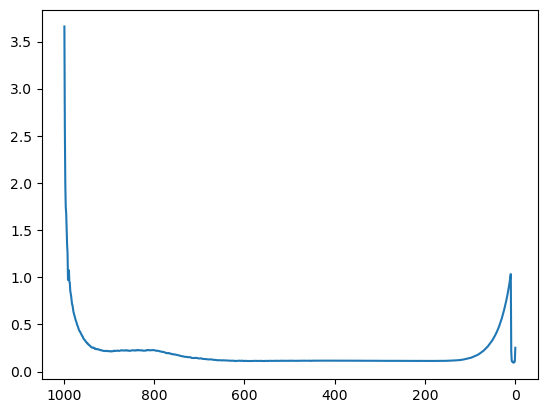

In [64]:
import numpy as np
import matplotlib.pyplot as plt
data = dict
t = list(data.keys())
print(t)
value = list(data.values())
fig, ax = plt.subplots()
ax.plot(t, value)
plt.gca().invert_xaxis()
plt.show()

In [85]:
new_dict = {999: 3.6597285608096675, 998: 2.5874720558690623, 997: 1.998275962054934, 996: 1.7432694737952998, 995: 1.6769287837286115, 994: 1.516683117146973, 993: 1.3444404120459268, 992: 1.2550966127433067, 991: 0.9713037059073192, 990: 1.075179525256035, 989: 1.074396734145633, 988: 0.9552880852271779, 987: 0.9401996624449852, 986: 0.8567062867028643, 985: 0.8296253252831122, 984: 0.7981023928299606, 983: 0.7587495792054691, 982: 0.7138278415394592, 981: 0.7014714168443983, 980: 0.6699202997213791, 979: 0.6348134315917966, 978: 0.6161085826887964, 977: 0.5935159445943444, 976: 0.5801647449802949, 975: 0.5596742951544544, 974: 0.5449090622510373, 973: 0.5332732461861308, 972: 0.518807671099938, 971: 0.4990388426885606, 970: 0.4868528370062124, 969: 0.4754024921492943, 968: 0.4580822323225933, 967: 0.444614598970991, 966: 0.4332904025305119, 965: 0.42373694354167135, 964: 0.42045297705385837, 963: 0.408417065867478, 962: 0.3995014852381497, 961: 0.3892950908444313, 960: 0.3847064123170893, 959: 0.37078470230335975, 958: 0.36790513559954735, 957: 0.3513443194407245, 956: 0.3452898096140031, 955: 0.3380337836662367, 954: 0.3340783116897702, 953: 0.3294122517814913, 952: 0.318704952046898, 951: 0.3151783828762191, 950: 0.30764101527637805, 949: 0.3022595107858528, 948: 0.3018706463805003, 947: 0.2910205770826052, 946: 0.28894727706527645, 945: 0.28509109606271693, 944: 0.2773987129795027, 943: 0.2763797187768687, 942: 0.2712262062160314, 941: 0.2671533715247717, 940: 0.2612006357292957, 939: 0.25593208549792645, 938: 0.2555574321233156, 937: 0.25569324538352145, 936: 0.2516636084139808, 935: 0.24937487007435505, 934: 0.2524562283428254, 933: 0.24864966668763772, 932: 0.24174317569824308, 931: 0.24226150700070306, 930: 0.24274560682541024, 929: 0.23789329252533334, 928: 0.23861338039316, 927: 0.23590551061307982, 926: 0.23619109298010055, 925: 0.2373477645973377, 924: 0.23716005561083764, 923: 0.2335237431402537, 922: 0.23219670268722817, 921: 0.2295265137082036, 920: 0.22871379273738804, 919: 0.22538540647153937, 918: 0.22654105780240366, 917: 0.22610388774426773, 916: 0.22343738039050004, 915: 0.22241566427850992, 914: 0.22076971154792846, 913: 0.21957442231946905, 912: 0.21813207427733539, 911: 0.21694312255548368, 910: 0.21860835087009933, 909: 0.21662792335584186, 908: 0.21778099514071456, 907: 0.21711370463746202, 906: 0.21968287613010626, 905: 0.2173037559605023, 904: 0.2168943478725421, 903: 0.21825800245472257, 902: 0.21756179569418077, 901: 0.21481779259041303, 900: 0.2148298851730396, 899: 0.21405191281592534, 898: 0.2169759743889723, 897: 0.21653627906143394, 896: 0.21534812902245307, 895: 0.2118399739881793, 894: 0.21343101924005292, 893: 0.21447015582777199, 892: 0.21552441781661114, 891: 0.21719067417271043, 890: 0.21627324844630466, 889: 0.22129014367247482, 888: 0.21990484898232424, 887: 0.21795012377340414, 886: 0.21840502252344024, 885: 0.21842016422311808, 884: 0.21835325824916307, 883: 0.21985836493611674, 882: 0.22240304512231412, 881: 0.22215839577700766, 880: 0.2208585486353948, 879: 0.21871098050987847, 878: 0.21877772286565494, 877: 0.2193632946258356, 876: 0.22032711292027143, 875: 0.22153579340835497, 874: 0.2234375637983366, 873: 0.22538676552794412, 872: 0.22519039998267018, 871: 0.2233385233487766, 870: 0.223078879901018, 869: 0.22351215109840566, 868: 0.22364146228900042, 867: 0.22232431422605956, 866: 0.22480273678368515, 865: 0.22387844506951207, 864: 0.22309424286933902, 863: 0.22217901112445693, 862: 0.22573025638224156, 861: 0.22545978771125386, 860: 0.2220626372640657, 859: 0.22259198527060978, 858: 0.2211438084944069, 857: 0.2186781932024635, 856: 0.21921340845028947, 855: 0.22213423337888613, 854: 0.22070738386084351, 853: 0.22010971639948942, 852: 0.22044756897260662, 851: 0.22202493304799426, 850: 0.2242308162532693, 849: 0.22492984208455333, 848: 0.225968782171929, 847: 0.22446130064078101, 846: 0.22390970057991147, 845: 0.22487242659522294, 844: 0.22261825349868886, 843: 0.2215672475256192, 842: 0.2236954405224078, 841: 0.22409798054210836, 840: 0.225905096327023, 839: 0.223865247952211, 838: 0.22602044743213257, 837: 0.22656483689024406, 836: 0.22430456471930074, 835: 0.22757678881236648, 834: 0.22692044482606108, 833: 0.22692950789888586, 832: 0.22674714252503597, 831: 0.2260475427271662, 830: 0.2237249690074765, 829: 0.22540411859151654, 828: 0.22451447441741032, 827: 0.22205357735722617, 826: 0.22332816271168743, 825: 0.223168369114512, 824: 0.2212075755419825, 823: 0.2199849398165156, 822: 0.2207185236207117, 821: 0.22203359335128725, 820: 0.2221011191959825, 819: 0.22158580675357892, 818: 0.22446507350421419, 817: 0.22522726350651306, 816: 0.22742174583164573, 815: 0.22505913531468252, 814: 0.22809481082278968, 813: 0.22754685750499412, 812: 0.22703776555418417, 811: 0.2263669305226263, 810: 0.22375862070610641, 809: 0.22424377526158232, 808: 0.22620951244068876, 807: 0.2265501469284603, 806: 0.22612990024425186, 805: 0.22595913532204384, 804: 0.22597081876152383, 803: 0.22652951358514214, 802: 0.22869108743621103, 801: 0.2272929211329258, 800: 0.22570738109905222, 799: 0.2239996437525374, 798: 0.22221129750398416, 797: 0.22277440693557346, 796: 0.22000457565430367, 795: 0.21924100871706617, 794: 0.22082155635911946, 793: 0.2200510646907362, 792: 0.21917851051257964, 791: 0.2190386114603817, 790: 0.21803718545588185, 789: 0.2157277881208404, 788: 0.21426655299491737, 787: 0.21420932784721575, 786: 0.21299408898054062, 785: 0.211964733484382, 784: 0.20955257968407673, 783: 0.20999875789159095, 782: 0.20852578002768446, 781: 0.20833680300841806, 780: 0.2073970096600745, 779: 0.2066238384981282, 778: 0.20592274435648636, 777: 0.2029862606930404, 776: 0.20039703158846858, 775: 0.19891094242760762, 774: 0.19803773447004083, 773: 0.19427510694269284, 772: 0.19482954797562357, 771: 0.19404912890080805, 770: 0.1943198956740155, 769: 0.19634413064857975, 768: 0.19345725207848996, 767: 0.19451485436610547, 766: 0.19223586797573478, 765: 0.19224593217741445, 764: 0.18999935584498873, 763: 0.1880051256796706, 762: 0.18538002352560215, 761: 0.18689488422644987, 760: 0.18396482592590646, 759: 0.1820161944646894, 758: 0.18314653420550636, 757: 0.18173162626959158, 756: 0.18195028578199646, 755: 0.18064687719350234, 754: 0.17957204159428894, 753: 0.17969912436660418, 752: 0.1782097390418353, 751: 0.17719061340170997, 750: 0.17598635363637585, 749: 0.17596068949476723, 748: 0.17354361311444144, 747: 0.17153577667187453, 746: 0.17207930624218054, 745: 0.1705673229605866, 744: 0.16804141318555904, 743: 0.16684482583855653, 742: 0.16643407759025933, 741: 0.1652575468991001, 740: 0.16308807043787132, 739: 0.16194019645638916, 738: 0.16085571095422346, 737: 0.16017475788832908, 736: 0.16145794695388743, 735: 0.16034368398441215, 734: 0.15777371451328248, 733: 0.15667500714578375, 732: 0.15684767449351972, 731: 0.1555115649566302, 730: 0.1550481742549195, 729: 0.15587123567893293, 728: 0.15415489725172019, 727: 0.15383267154490327, 726: 0.15208318780835026, 725: 0.15155469069587463, 724: 0.15096075726229338, 723: 0.15231298619465383, 722: 0.15303671518147485, 721: 0.15236794435249215, 720: 0.15090648693718076, 719: 0.14925354346432768, 718: 0.14738401274819934, 717: 0.14360420101901264, 716: 0.1436648100239455, 715: 0.14393143465105504, 714: 0.1430744391230306, 713: 0.1431676238496751, 712: 0.14254610354791888, 711: 0.14400568966626692, 710: 0.14390435976748128, 709: 0.14388676884393553, 708: 0.1435927327866068, 707: 0.14430036462155513, 706: 0.1446974269471231, 705: 0.14290105557913202, 704: 0.14046227320251373, 703: 0.14033843165834345, 702: 0.13920382987137656, 701: 0.13796460616469527, 700: 0.1380912350221604, 699: 0.13795222990419093, 698: 0.13882088819999938, 697: 0.13876230924427457, 696: 0.14013727367769424, 695: 0.13850975096870505, 694: 0.1370233642805724, 693: 0.1350008574988248, 692: 0.13349557752774727, 691: 0.133341372011916, 690: 0.13327178218276994, 689: 0.13408106980652662, 688: 0.1333167510916706, 687: 0.13337704903390224, 686: 0.13283366558620033, 685: 0.1316890079544527, 684: 0.13061538838199646, 683: 0.12911522629357292, 682: 0.1297534440161488, 681: 0.12905656339696056, 680: 0.12783430432909246, 679: 0.1277532334512064, 678: 0.12740978273784248, 677: 0.12855759139526027, 676: 0.1290706735514702, 675: 0.12895658403422303, 674: 0.128087712971453, 673: 0.1284815554169013, 672: 0.1268026576656298, 671: 0.12646258349879688, 670: 0.12574295966783297, 669: 0.12454983294022709, 668: 0.12302522101096111, 667: 0.12393150196193205, 666: 0.12298345209991515, 665: 0.12256795231167236, 664: 0.12294069609181488, 663: 0.12180465288362817, 662: 0.12062778542020876, 661: 0.1209810803094206, 660: 0.11989736970249107, 659: 0.11922961904465365, 658: 0.11895261189926373, 657: 0.11967795208669298, 656: 0.11948279712452785, 655: 0.12034847060919018, 654: 0.1195688537969974, 653: 0.11920139956872462, 652: 0.11823924879374614, 651: 0.11804055303999487, 650: 0.11774016292825455, 649: 0.11898965553920413, 648: 0.11889069511114149, 647: 0.11810797601082465, 646: 0.11837628320641348, 645: 0.1186997823144944, 644: 0.118406347964247, 643: 0.1182841495316783, 642: 0.11828438471609998, 641: 0.11758051543942025, 640: 0.11708737706729713, 639: 0.11687796775317955, 638: 0.11665864709144795, 637: 0.11614202793528229, 636: 0.11522321255184326, 635: 0.11577640464169998, 634: 0.1146756936460227, 633: 0.11444513300734278, 632: 0.11480640564416855, 631: 0.11374841512248413, 630: 0.11467094380506405, 629: 0.11455999863212239, 628: 0.11461179521977818, 627: 0.11391009564992038, 626: 0.11562916888434106, 625: 0.113841255166323, 624: 0.11461283791741905, 623: 0.113007835205302, 622: 0.11330864105760213, 621: 0.11297301555419222, 620: 0.1105418979341477, 619: 0.11175502353724374, 618: 0.11232030979152316, 617: 0.11247070756163295, 616: 0.11308725791817859, 615: 0.11264224242837893, 614: 0.11354939274724789, 613: 0.11264192969773987, 612: 0.11431994935800711, 611: 0.1143581923353847, 610: 0.11523372006345142, 609: 0.11307235049563134, 608: 0.11331253829432628, 607: 0.11428399518225729, 606: 0.11264426299806266, 605: 0.1145754714537727, 604: 0.11290454902007681, 603: 0.11270240729529961, 602: 0.11348219457211522, 601: 0.11285585176637498, 600: 0.11056174516227463, 599: 0.11151923115451019, 598: 0.11386650459140245, 597: 0.11267104854520085, 596: 0.11266633627471342, 595: 0.11184628728135232, 594: 0.1116108958309197, 593: 0.11153979338792354, 592: 0.112093188590543, 591: 0.11218500620723183, 590: 0.11154078838790099, 589: 0.11209600493361231, 588: 0.11144769318657989, 587: 0.1120144798065388, 586: 0.11126552018364433, 585: 0.11163106988886783, 584: 0.11232288330765688, 583: 0.1118288239037924, 582: 0.11242931630603746, 581: 0.1111477892757159, 580: 0.11215099747081297, 579: 0.11263412098953934, 578: 0.11334408226922284, 577: 0.11311139890992275, 576: 0.1123226442012132, 575: 0.11259641458672459, 574: 0.11220966777692151, 573: 0.11191737514760416, 572: 0.11160677386527858, 571: 0.11233921800479756, 570: 0.1128263756994814, 569: 0.11184932880942583, 568: 0.1123627766060816, 567: 0.11170654218212851, 566: 0.1141832837558416, 565: 0.11315629466762062, 564: 0.11254032338128665, 563: 0.11254214548755848, 562: 0.11321389935093559, 561: 0.11117670196806612, 560: 0.11145124433411831, 559: 0.11247564202648551, 558: 0.111873601053157, 557: 0.11194284095695989, 556: 0.11109476883002, 555: 0.11127445761617784, 554: 0.11296049141953494, 553: 0.11306510320001095, 552: 0.11281567314234361, 551: 0.11229012228032781, 550: 0.11261062178117665, 549: 0.11154211512403431, 548: 0.11229356303347125, 547: 0.11285238759295659, 546: 0.1127939531533171, 545: 0.11344077756892207, 544: 0.11322974787361076, 543: 0.11193517862737462, 542: 0.11210624663782914, 541: 0.11241359563749653, 540: 0.11248268770047525, 539: 0.11326910273485032, 538: 0.11263802886857172, 537: 0.11279353160634056, 536: 0.11264155561505916, 535: 0.11282992926116857, 534: 0.11230899244938257, 533: 0.11227602437514961, 532: 0.11227796209175434, 531: 0.11277557042421503, 530: 0.1140308298864343, 529: 0.11221626084424124, 528: 0.11351480236721408, 527: 0.11394062853600226, 526: 0.11338089314634228, 525: 0.11367493089589852, 524: 0.11278032283608992, 523: 0.1130208997621063, 522: 0.11239693352733442, 521: 0.11321606623433117, 520: 0.11396025187085113, 519: 0.1144499967910547, 518: 0.11193797530366953, 517: 0.11406322675137552, 516: 0.11441345619394482, 515: 0.11352502384878849, 514: 0.11415159626541618, 513: 0.11414801654333222, 512: 0.11414423696085091, 511: 0.11292835493044233, 510: 0.1136151531661768, 509: 0.11344730898629608, 508: 0.11441727711647055, 507: 0.11386445764957304, 506: 0.11251916716337179, 505: 0.11308845740204602, 504: 0.1134453965324305, 503: 0.11459530710301263, 502: 0.11436475014595765, 501: 0.11355732995691303, 500: 0.11435728566232105, 499: 0.11231800382498544, 498: 0.11467999022615913, 497: 0.11397561706516028, 496: 0.1140660000961156, 495: 0.11448493469066622, 494: 0.11393995108765631, 493: 0.11419058685129567, 492: 0.11382056113489822, 491: 0.11367673181554055, 490: 0.11371283882311721, 489: 0.11407764944714749, 488: 0.11339824059286595, 487: 0.11343851414382906, 486: 0.11439125859464094, 485: 0.11428107170097779, 484: 0.11299274427480109, 483: 0.11478542940496411, 482: 0.11393780295329141, 481: 0.1139853857408437, 480: 0.112797877508899, 479: 0.11395560843286542, 478: 0.11432201852107839, 477: 0.11480365097781355, 476: 0.11376830661371533, 475: 0.11360130314498859, 474: 0.1138182825570544, 473: 0.11372043049955859, 472: 0.1140095340489786, 471: 0.11389569993090477, 470: 0.11397213871407351, 469: 0.11506815616683172, 468: 0.11338241779180117, 467: 0.1146957809159297, 466: 0.11488865819918402, 465: 0.1140506888541011, 464: 0.11427884034861989, 463: 0.11397223160367047, 462: 0.11409548049557207, 461: 0.11432300883389196, 460: 0.11404638804310097, 459: 0.11409690633713711, 458: 0.11453627346089175, 457: 0.11413535812978005, 456: 0.11491169345221902, 455: 0.11520537672959603, 454: 0.11486926773881895, 453: 0.11210536817769935, 452: 0.11317332006416632, 451: 0.1148256160832515, 450: 0.11435722048030782, 449: 0.11478912506136592, 448: 0.11554844825080438, 447: 0.11346001549004704, 446: 0.11461318926519715, 445: 0.11509756598678376, 444: 0.11429246570182368, 443: 0.115313950160999, 442: 0.11473042874237604, 441: 0.11498208648429262, 440: 0.11493360447663001, 439: 0.11423337490908433, 438: 0.11463321298149112, 437: 0.11535333641739248, 436: 0.11435498241468786, 435: 0.11368212196446777, 434: 0.11468044503066699, 433: 0.1145677668430112, 432: 0.11520748643780884, 431: 0.11514687901178175, 430: 0.11451194552808114, 429: 0.11521178402758289, 428: 0.11477370656970871, 427: 0.11481633186822564, 426: 0.11522779472741126, 425: 0.11501691895825163, 424: 0.11487381568416352, 423: 0.11512827437516376, 422: 0.115440121108343, 421: 0.11554372300120082, 420: 0.11503831718557916, 419: 0.1150593159141288, 418: 0.11535260303247824, 417: 0.11520761840408623, 416: 0.1146673374231422, 415: 0.11448713348105377, 414: 0.11480202344105567, 413: 0.11487119231033929, 412: 0.11415673584748712, 411: 0.11529606363135829, 410: 0.11509159965511392, 409: 0.1148921549865839, 408: 0.1149360327474383, 407: 0.1155571826104389, 406: 0.11518091889946246, 405: 0.11387307347158106, 404: 0.11529997624209472, 403: 0.11537574305609276, 402: 0.11569300284471914, 401: 0.11500889732330252, 400: 0.11557565219777549, 399: 0.11523566348307658, 398: 0.11551752973069018, 397: 0.11542473876722083, 396: 0.1153936430024499, 395: 0.11495232334507834, 394: 0.11393332859222736, 393: 0.1149270333547985, 392: 0.11498986190647, 391: 0.11498711549036525, 390: 0.11485716531314853, 389: 0.1150151981280158, 388: 0.11522180600712899, 387: 0.11529897276944544, 386: 0.1155379260360878, 385: 0.11536522686016487, 384: 0.11535957212649525, 383: 0.11483291414833953, 382: 0.11503061420795704, 381: 0.11538379867198234, 380: 0.11522369559301243, 379: 0.11514573045669418, 378: 0.11563840728708161, 377: 0.11490770356658955, 376: 0.11555377909827562, 375: 0.11517384251784986, 374: 0.11481152470875379, 373: 0.11508432906631667, 372: 0.11488493438989889, 371: 0.11486226084303633, 370: 0.11454237483488816, 369: 0.11512048478195001, 368: 0.11469079128420856, 367: 0.11461399132058822, 366: 0.11441478021795831, 365: 0.11471897542338187, 364: 0.11474345481748291, 363: 0.11435082705195787, 362: 0.1143703377223163, 361: 0.1143748801680777, 360: 0.11473292166334419, 359: 0.11459963817687924, 358: 0.11475191728895794, 357: 0.11416631578483105, 356: 0.1148509785275604, 355: 0.11482668195794733, 354: 0.11444465538568746, 353: 0.11477884020241512, 352: 0.11409005082395009, 351: 0.11467666059843888, 350: 0.11465606657171043, 349: 0.11399620977257127, 348: 0.1144169247532659, 347: 0.11398385753905776, 346: 0.11410393736331771, 345: 0.11452438623222436, 344: 0.11457057700436465, 343: 0.11454159783155704, 342: 0.11447298148552015, 341: 0.11298676533028934, 340: 0.11441229115339499, 339: 0.11460926299559092, 338: 0.11414820879668605, 337: 0.11402542677631676, 336: 0.11412374122454978, 335: 0.11430134976115144, 334: 0.11432836812202221, 333: 0.11405405458194708, 332: 0.11376195903577968, 331: 0.11365076904570315, 330: 0.11410215473817807, 329: 0.11395424841612269, 328: 0.11345950135078421, 327: 0.11418356204300817, 326: 0.11425802871588442, 325: 0.114134880090051, 324: 0.11413094763383812, 323: 0.11418111865941782, 322: 0.1140529759672359, 321: 0.11395208072801169, 320: 0.11376809198379835, 319: 0.11393622347181062, 318: 0.11375138892670618, 317: 0.11402212207283838, 316: 0.11390241573615133, 315: 0.11371051229162613, 314: 0.11301939229298785, 313: 0.11397199557779254, 312: 0.11343848362253628, 311: 0.11384640091732881, 310: 0.11344111240912666, 309: 0.11367982156175306, 308: 0.11332040877639342, 307: 0.11354684632671562, 306: 0.11365375721345254, 305: 0.11370457531385786, 304: 0.11379403361587288, 303: 0.11385257422458925, 302: 0.11309732871476147, 301: 0.11346592970704097, 300: 0.11367477615109506, 299: 0.11375786886828004, 298: 0.11382164691623796, 297: 0.11337379620807145, 296: 0.11363726182278877, 295: 0.11347532373427197, 294: 0.11357995535268768, 293: 0.11358458219074118, 292: 0.11354448246776522, 291: 0.11349127897743398, 290: 0.11355077333366538, 289: 0.11313077136898454, 288: 0.1133947670166741, 287: 0.11353624682732938, 286: 0.11316029839896379, 285: 0.11357761058962375, 284: 0.11365988958794111, 283: 0.11299000597414745, 282: 0.11334864369035245, 281: 0.11325385069208486, 280: 0.11317117787592887, 279: 0.11234242022238722, 278: 0.11333789296687227, 277: 0.11326041365287996, 276: 0.11297425774046055, 275: 0.11331246033054497, 274: 0.11325329506308877, 273: 0.11329130953408538, 272: 0.11325692961522257, 271: 0.11320823794952727, 270: 0.11316694194420283, 269: 0.113040006298037, 268: 0.11265231905545041, 267: 0.11307760983927041, 266: 0.11252105690012261, 265: 0.11271104004584123, 264: 0.11277220295314744, 263: 0.11298834262272932, 262: 0.11253145795803332, 261: 0.1125124245817065, 260: 0.11269736200210717, 259: 0.11293381888718493, 258: 0.11300287359537314, 257: 0.11301236730531548, 256: 0.11289713937463676, 255: 0.11271168725964284, 254: 0.11267238154642205, 253: 0.11231097585996634, 252: 0.11282722310692722, 251: 0.11267919284559533, 250: 0.11277774986410691, 249: 0.11289028049834463, 248: 0.11289329466207401, 247: 0.11265899170097093, 246: 0.1127690400518995, 245: 0.1125041143965103, 244: 0.11268597880563917, 243: 0.11246982777447037, 242: 0.11251377680523424, 241: 0.11247861862387831, 240: 0.11206009398154904, 239: 0.11231538229907707, 238: 0.1116045201116419, 237: 0.11218119861154116, 236: 0.11218669468412104, 235: 0.1120808241087106, 234: 0.11230898107815868, 233: 0.11234510140180576, 232: 0.11209981785944721, 231: 0.11228819820565834, 230: 0.11240221483141945, 229: 0.11239408143886195, 228: 0.11245281835593744, 227: 0.11259275600573342, 226: 0.11264790443629868, 225: 0.11282378871503039, 224: 0.11269179109404119, 223: 0.11245829194784403, 222: 0.1127566389946307, 221: 0.11213240756712661, 220: 0.11179460436583745, 219: 0.11241939523053797, 218: 0.11256868491135809, 217: 0.11262044363550543, 216: 0.11202487675643105, 215: 0.11268149212140069, 214: 0.11270317605005926, 213: 0.11264555818118743, 212: 0.11263943603199558, 211: 0.11283026487442081, 210: 0.11256509513805617, 209: 0.11284915697261862, 208: 0.11271567257558086, 207: 0.1127124772574197, 206: 0.11278396714923633, 205: 0.11277602560225404, 204: 0.11270265875269343, 203: 0.1126572152178747, 202: 0.11228615983257671, 201: 0.11272297242883667, 200: 0.11208178555969592, 199: 0.11269313396669126, 198: 0.11267555897884553, 197: 0.11249384698573218, 196: 0.11249784943437094, 195: 0.1125671627546811, 194: 0.11246864530586431, 193: 0.11172045747471683, 192: 0.11218898378240805, 191: 0.11255513398524578, 190: 0.11195443374647641, 189: 0.11225275703516545, 188: 0.11252719602309773, 187: 0.11232660423195479, 186: 0.11188603358674304, 185: 0.11214236750245844, 184: 0.11248334117584541, 183: 0.1121057630080332, 182: 0.11234332022711287, 181: 0.11180263838951207, 180: 0.11224298134038278, 179: 0.11239820259997614, 178: 0.11254025197471358, 177: 0.1123817600363278, 176: 0.11255099213209713, 175: 0.11226999163335581, 174: 0.11235163157616854, 173: 0.11254593254316057, 172: 0.1127046144631538, 171: 0.11280939010397421, 170: 0.1125783979188574, 169: 0.11298444875339628, 168: 0.11213563175612445, 167: 0.11277900795159035, 166: 0.11326344355302499, 165: 0.11343805152822893, 164: 0.11295586026387121, 163: 0.11353552419464955, 162: 0.11275412303612169, 161: 0.11297168110558227, 160: 0.11333727772418474, 159: 0.11295452935754952, 158: 0.11308768635796165, 157: 0.11315851052488848, 156: 0.11343573319975175, 155: 0.11351281596323491, 154: 0.11329562696793777, 153: 0.11277076976292703, 152: 0.11320159683289659, 151: 0.11376286689734284, 150: 0.11393807167594286, 149: 0.1140863637327114, 148: 0.113860238680389, 147: 0.11414687763970154, 146: 0.11493833793724224, 145: 0.11457741492112693, 144: 0.11542157601305478, 143: 0.11537610822576072, 142: 0.11550109672367094, 141: 0.11580584246963888, 140: 0.1154068924865129, 139: 0.11628981959850229, 138: 0.11632967232341127, 137: 0.1170300167892049, 136: 0.1170319926391767, 135: 0.11750622674143003, 134: 0.11793166791048197, 133: 0.11747325050859769, 132: 0.11821851555309115, 131: 0.11832582868312297, 130: 0.11849684722306639, 129: 0.11917431436494667, 128: 0.1196111130734658, 127: 0.11966026832573007, 126: 0.12058689571333442, 125: 0.12023756753495149, 124: 0.12126972187370309, 123: 0.12200923455706376, 122: 0.12260670482185854, 121: 0.12202419270288554, 120: 0.12384295157981551, 119: 0.12441371478020796, 118: 0.1250209715953512, 117: 0.12597983020424572, 116: 0.12665769050889006, 115: 0.12760469235487099, 114: 0.12817280198029268, 113: 0.12925819055332655, 112: 0.1302466062058591, 111: 0.13114967684564452, 110: 0.13220798977795184, 109: 0.1329248774973663, 108: 0.1339834853189651, 107: 0.13484610660825871, 106: 0.13615667669031506, 105: 0.13714128937202186, 104: 0.13807731432141696, 103: 0.13961304376851705, 102: 0.1410684043637139, 101: 0.1421130195610882, 100: 0.1437954326998116, 99: 0.14532011968881273, 98: 0.14644543528229273, 97: 0.14839547695463737, 96: 0.15016975929622348, 95: 0.1519550407401379, 94: 0.15340341446950534, 93: 0.15531947511122418, 92: 0.1575484777320401, 91: 0.15981308817321194, 90: 0.16143654789261674, 89: 0.16341203871589957, 88: 0.16566129317816813, 87: 0.16782597559056356, 86: 0.17054211331105956, 85: 0.17302535369479816, 84: 0.17512520529152834, 83: 0.17757820066918506, 82: 0.18026464208466475, 81: 0.18395111493043437, 80: 0.1868276538892755, 79: 0.1903464858029739, 78: 0.19314630621460488, 77: 0.19678215029862867, 76: 0.2002998820123606, 75: 0.20387975654572127, 74: 0.2069794289471972, 73: 0.21092618427611767, 72: 0.21506885797306968, 71: 0.21889670287635052, 70: 0.22244877791559206, 69: 0.22722767535100874, 68: 0.23181169150624958, 67: 0.23633241796661783, 66: 0.2409937664707653, 65: 0.24507774776082852, 64: 0.25062515139710506, 63: 0.2558406395629851, 62: 0.26038368955300256, 61: 0.26577063627966285, 60: 0.2721725331490555, 59: 0.2773705485980513, 58: 0.28368917445110287, 57: 0.2897409051025745, 56: 0.2962531419981592, 55: 0.3024000644715404, 54: 0.30878608580482175, 53: 0.31615556897431374, 52: 0.32329672144553817, 51: 0.3301511717119567, 50: 0.33835685500196017, 49: 0.3741029192864521, 48: 0.4368343285133293, 47: 0.5015264923869794, 46: 0.5678258747116725, 45: 0.6317376114926675, 44: 0.6962432786249529, 43: 0.7569560381656611, 42: 0.8180535187562518, 41: 0.8783661527465187, 40: 0.9383693744474702, 39: 0.9991799884121417, 38: 1.0562799541439802, 37: 1.1130463909618056, 36: 1.1675734362949348, 35: 1.2205221618222508, 34: 1.2713500334208532, 33: 1.3195405899406156, 32: 1.3649595917392443, 31: 1.4064961109106777, 30: 1.4436185448833438, 29: 1.4784745922365805, 28: 1.508037930758615, 27: 1.5352263899893785, 26: 1.5568133782025475, 25: 1.5783535223255496, 24: 1.5981585427275096, 23: 1.6196006834973267, 22: 1.642402533666942, 21: 1.6663245829119244, 20: 1.6930670367233298, 19: 1.721805086189552, 18: 1.7529239452446135, 17: 1.7852207400068283, 16: 1.8187285160275948, 15: 1.8549811727112422, 14: 1.8911209343244813, 13: 1.9285967862964715, 12: 1.9669741180921392, 11: 2.0060550756385616, 10: 2.0484983148005025, 9: 1.2765731030881653, 8: 1.1313798618090203, 7: 1.0360614899330256, 6: 0.9635603947436185, 5: 0.9163173619337674, 4: 0.8958131480036376, 3: 0.9074888918406542, 2: 0.9620893935887871, 1: 1.0849350421725417, 0: 1.4526719147615683}

[999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986, 985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972, 971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958, 957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944, 943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930, 929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916, 915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888, 887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874, 873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811, 810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800,

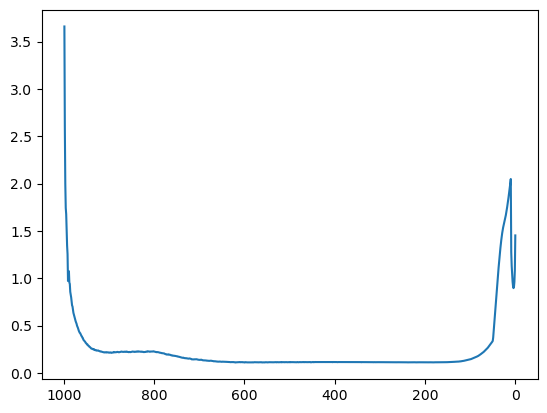

In [86]:
data = new_dict
t = list(data.keys())
print(t)
value = list(data.values())
fig, ax = plt.subplots()
ax.plot(t, value)
plt.gca().invert_xaxis()
plt.show()

In [104]:
flag = torch.tensor(np.zeros((2,4,69)))
flag[0][1][30:] = 1
flag[1][2][32:] = 1

In [107]:
gt_move_flag = flag.sum(dim=-1)>0
# print(gt_move_flag.shape)
gt_move_index = torch.where(gt_move_flag==1)
print(gt_move_index)
gt_active_flag = flag[gt_move_index]
gt_class = gt_move_index[1].long()
print(gt_active_flag)
torch.where(gt_active_flag==1)
torch.argmax(gt_active_flag,dim=-1)

(tensor([0, 1]), tensor([1, 2]))
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       dtype=torch.float64)


tensor([30, 32])

In [112]:
def lengths_to_mask_after(lengths, max_len):
    # max_len = max(lengths)
    mask = torch.arange(max_len - 1, -1, -1).expand(len(lengths), max_len) < lengths.unsqueeze(1)
    return mask

lengths_to_mask_after(torch.tensor([3,3]),5)

tensor([[False, False,  True,  True,  True],
        [False, False,  True,  True,  True]])

# 可视化检查转换关系

In [62]:
import torch
import numpy as np
from os.path import join
import pickle
from utils.data_util import *
seqs = ['0164','0327']
# seqs = ['0164']
root = '/root/code/seqs/1205_data/'
local_motion = torch.randn((2,60,99))
pad_motion = torch.randn((2,60,51))
global_motion = torch.randn((2,60,99))
global_mean = np.load('dataset/gazehoi_global_motion_6d_mean.npy')
global_std = np.load('dataset/gazehoi_global_motion_6d_std.npy')
local_mean = np.load('dataset/gazehoi_local_motion_6d_mean.npy')
local_std = np.load('dataset/gazehoi_local_motion_6d_std.npy')
for i in range(2):
    seq = seqs[i]
    seq_path = join(root,seq)
    meta_path = join(seq_path,'meta.pkl')
    mano_right_path = join(seq_path, 'mano/poses_right.npy')

    with open(meta_path,'rb')as f:
        meta = pickle.load(f)
    
    hand_params = np.load(mano_right_path)
    hand_pose_axis = torch.tensor(hand_params[:,:51])
    hand_trans = hand_pose_axis[:,:3]
    hand_theta = hand_pose_axis[:,3:]
    mano_beta = torch.tensor(hand_params[:,51:])

    ##
    goal_index = meta['goal_index']
    print(goal_index)

    seq_length = goal_index + 1
    length = 60
    
    """0229晚pad版本 补在后边"""
    if goal_index == 0:
        goal_index = 1
    if goal_index < 59:
        pad_hand_pose_axis = hand_pose_axis[:goal_index].numpy()
        print(length,seq_length)
        pad_width = ((0,length-seq_length+1), (0, 0))
        pad_hand_pose_axis = np.pad(pad_hand_pose_axis, pad_width, mode='edge')
        print(pad_hand_pose_axis.shape)
        pad_hand_pose_axis = torch.tensor(pad_hand_pose_axis).unsqueeze(0)
    else:
        print('here')
        pad_hand_pose_axis = hand_pose_axis[goal_index-60:goal_index].unsqueeze(0)
        seq_length = 60
    pad_motion[i] = pad_hand_pose_axis.squeeze(0)
    local_hand_pose_axis = global2local_axis_by_matrix(pad_hand_pose_axis)
    local_hand_pose_6d = axis2rot6d(local_hand_pose_axis).squeeze(0).numpy()
    local_hand_pose_6d = (local_hand_pose_6d - local_mean) / local_std
    print(local_hand_pose_6d.shape)
    local_motion[i] = torch.tensor(local_hand_pose_6d)

    global_hand_pose_6d = axis2rot6d(pad_hand_pose_axis).squeeze(0).numpy()
    global_hand_pose_6d = (global_hand_pose_6d - global_mean) / global_std
    global_motion[i] = torch.tensor(global_hand_pose_6d)


64
here
(60, 99)
57
60 58
(60, 51)
(60, 99)


In [63]:
global_mean = torch.from_numpy(np.load('dataset/gazehoi_global_motion_6d_mean.npy'))
global_std = torch.from_numpy(np.load('dataset/gazehoi_global_motion_6d_std.npy'))
local_mean = torch.from_numpy(np.load('dataset/gazehoi_local_motion_6d_mean.npy'))
local_std = torch.from_numpy(np.load('dataset/gazehoi_local_motion_6d_std.npy'))
sample = local_motion
sample = sample * local_std + local_mean 
sample = local2global_rot6d_by_matrix(sample)
sample = rot6d2axis(sample)

In [41]:
sample.shape

torch.Size([2, 60, 51])

In [64]:
print(sample[0,:,:3]-pad_motion[0,:,:3])

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0

In [65]:
npy_path = 'save/test_trans/results.npy'
np.save(npy_path,{'motion': sample.cpu().numpy(), 'seqs':seqs})